In [8]:
from jax import jit
from main import *
from functools import partial
import time as tm
m = bi(platform='cpu')

jax.local_device_count 1


Probability distributions creation

In [2]:
dist.exponential

<bound method Dist.exponential of <dists.Dist object at 0x7f195bf47fd0>>

Sampler for pdf

In [3]:
sample.exponential(sample_shape = (1,), seed = 0)

Array([0.5420704], dtype=float32)

random centered factor

In [4]:
random

gaussian related functions

In [5]:
gaussian

network related function

In [6]:
net

In [46]:
import jax.numpy as jnp
mat = jnp.array([[1, 2, 3, 4],
                [5, 6, 7, 8],
                [9, 10, 11, 12],
                [13, 14, 15, 16]])



In [47]:
from jax import jit
@jit
def diag_pre_multiply(v, m):
    return jnp.matmul(jnp.diag(v), m)#
@jit
def random_centered(sigma, cor_mat, offset_mat):
    """Generate the centered matrix of random factors #
    Args:
        sigma (vector): Prior, vector of length N
        cor_mat (2D array): correlation matrix, cholesky_factor_corr of dim N, N
        offset_mat (2D array): matrix of offsets, matrix of dim N*k#
    Returns:
        _type_: 2D array
    """
    return jnp.dot(diag_pre_multiply(sigma, cor_mat), offset_mat)

In [11]:
from functools import partial
@partial(jit, static_argnums=(1, 2,))
def vec_to_mat(arr, N, K):
    return jnp.reshape(arr, (N, K))

vec = jnp.array([1,2,3,4])

receiver = jnp.tile(vec, (4,1))
sender = receiver.T
print(receiver)
print(sender)

[[1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]
 [1 2 3 4]]
[[1 1 1 1]
 [2 2 2 2]
 [3 3 3 3]
 [4 4 4 4]]


In [12]:
from jax import vmap
N_id = 4
sr_raw =  sample.normal(0, 1, sample_shape=(N_id, 2))
sr_sigma =  sample.exponential(1, sample_shape= (2,))
sr_L = sample.lkjcholesky(2, 4)
rf_sr = vmap(lambda x: random_centered(sr_sigma, sr_L, x))(sr_raw)


In [13]:
dr_raw =  sample.normal(0, 1, sample_shape=(int(N_id*(N_id-1)/2), 2))
dr_sigma =  sample.exponential(1, sample_shape= (2,))
dr_L = sample.lkjcholesky(2, 4)
rf_dr = vmap(lambda x: random_centered(dr_sigma, dr_L, x))(dr_raw)
rf_dr

Array([[ 0.29007038, -2.0102808 ],
       [ 0.10813467,  0.8829876 ],
       [-0.09551398,  1.19697   ],
       [ 0.11215734, -3.4375284 ],
       [-0.05224978, -1.5608484 ],
       [-0.165471  ,  0.574221  ]], dtype=float32)

In [81]:
def edgl_to_mat(edgl, N_id):
    m = jnp.zeros((N_id,N_id))
    urows, ucols   = jnp.triu_indices(N_id, 1)
    m = m.at[(urows, ucols)].set(edgl[:,0])
    m = m.T
    m2 = m.at[(urows, ucols)].set(edgl[:,1])
    return m2
edgl_to_mat(rf_dr, 4)

Array([[ 0.        , -2.0102808 ,  0.8829876 ,  1.19697   ],
       [ 0.29007038,  0.        , -3.4375284 , -1.5608484 ],
       [ 0.10813467,  0.11215734,  0.        ,  0.574221  ],
       [-0.09551398, -0.05224978, -0.165471  ,  0.        ]],      dtype=float32)

In [16]:
output = jnp.ones((4,4))
output = output.at[jnp.diag_indices(4)].set(jnp.nan)
output


Array([[nan,  1.,  1.,  1.],
       [ 1., nan,  1.,  1.],
       [ 1.,  1., nan,  1.],
       [ 1.,  1.,  1., nan]], dtype=float32)

In [18]:
edgl_to_mat(rf_dr)

Array([[ 0.        , -2.0102808 ,  0.8829876 ,  1.19697   ],
       [ 0.29007038,  0.        , -3.4375284 , -1.5608484 ],
       [ 0.10813467,  0.11215734,  0.        ,  0.574221  ],
       [-0.09551398, -0.05224978, -0.165471  ,  0.        ]],      dtype=float32)

In [22]:
from jax import jit
from main import *
from functools import partial
import time as tm
m = bi(platform='cpu')

N_id = 4
def model(N_id, result_outcomes):
    # sr-----------------------------------------------------------------------------------
    sr_raw =  dist.normal('sr_raw', 0, 1, sample_shape=(N_id, 2))
    sr_sigma =  dist.exponential('sr_sigma', 1, sample_shape= (2,))
    sr_L = dist.lkjcholesky('sr_L', 2, 4)
    rf_sr = vmap(lambda x: random_centered(sr_sigma, sr_L, x))(sr_raw)

    rf_receiver = jnp.tile(rf_sr[:,0], (4,1))
    rf_sender = jnp.tile(rf_sr[:,1], (4,1))
    print('sr ok ')

    # dr -----------------------------------------------------------------------------------
    dr_raw =  dist.normal('dr_raw', 0, 1, sample_shape=(int(N_id*(N_id-1)/2), 2))
    dr_sigma =  dist.exponential('dr_sigma', 1, sample_shape= (2,))
    dr_L = dist.lkjcholesky('dr_L', 2, 4)
    rf_dr = vmap(lambda x: random_centered(dr_sigma, dr_L, x))(dr_raw)
    print('dr ok ')

    lk('Y', Bernoulli(logits = 1 +  rf_receiver + rf_sender + edgl_to_mat(rf_dr)), obs=result_outcomes)

dat = dict(
    N_id = N_id,
    result_outcomes = output,
)

m = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=1)
m.run(random.PRNGKey(0), **dat)
res = az.from_numpyro(m)
res

jax.local_device_count 1
sr ok 
dr ok 
sr ok 
dr ok 
sr ok 
dr ok 
sr ok 
dr ok 


/tmp/ipykernel_4026878/4042951325.py:34: UserWarning: Site Y: Out-of-support values provided to log prob method. The value argument should be within the support.
  m.run(random.PRNGKey(0), **dat)


RuntimeError: Cannot find valid initial parameters. Please check your model again.

In [ ]:
        lk('Y', Poisson(jnp.exp(B[0] + sr + dr)), obs=result_outcomes)

dat = dict(
    N_id = N_id,
    result_outcomes = result_outcomes,
    d_s = d_s, d_r = d_r,
    focal_individual_predictors = focal_individual_predictors,
    target_individual_predictors = target_individual_predictors,
    outcome_mode = int(3),
    exposure = mat_to_edgl(exposure)
)
m = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=1)
m.run(random.PRNGKey(0), **dat)
res = az.from_numpyro(m)

# Jax functions

## Overall

In [ ]:
#init_key, sample_key = random.split(random.PRNGKey(int(r.randint(0, 10000000))))
#init_key = jnp.array(init_key)

@partial(jit, static_argnums=(1, 2,))
def vec_to_mat(arr, N, K):
    return jnp.reshape(arr, (N, K))

@jit
def jax_LinearOperatorDiag(s, cov):    
    def multiply_with_s(a):
        return jnp.multiply(a, s)
    vectorized_multiply = vmap(multiply_with_s)
    return jnp.transpose(vectorized_multiply(cov))
import jax.numpy as jnp

@jit
def diag_pre_multiply(v, m):
    return jnp.matmul(jnp.diag(v), m)

@jit
def random_centered(sigma, cor_mat, offset_mat):
    """Generate the centered matrix of random factors 

    Args:
        sigma (vector): Prior, vector of length N
        cor_mat (2D array): correlation matrix, cholesky_factor_corr of dim N, N
        offset_mat (2D array): matrix of offsets, matrix of dim N*k

    Returns:
        _type_: 2D array
    """
    return jnp.dot(diag_pre_multiply(sigma, cor_mat), offset_mat)



## For networks

In [ ]:
import jax.random as jaxr

@jit
def logit(x):
    return jnp.log(x / (1 - x))


@jit
def apply_row_dotproduct(A, v):
    """
    Perform matrix-vector multiplication for each row of the array v.

    Parameters:
    A (jax.numpy.ndarray): A 2x2 matrix.
    v (jax.numpy.ndarray): An array of shape (n, 2) where each row is a 2-vector.

    Returns:
    jax.numpy.ndarray: An array of shape (n, 2) where each row is the result of the matrix-vector multiplication.
    """
    # Define a function that performs the matrix-vector multiplication
    def dotvec(A, v):
        return jnp.dot(A, v)
    
    # Vectorize the function using jax.vmap
    vmap_dotvec = jax.vmap(lambda v: dotvec(A, v))
    
    # Apply the vectorized function to the array of vectors
    result = vmap_dotvec(v)
    
    return result

@jit
def apply_row_matmul(v, A):
    """
    Perform matrix-vector multiplication for each row of the array v.

    Parameters:
    A (jax.numpy.ndarray): A 2x2 matrix.
    v (jax.numpy.ndarray): An array of shape (n, 2) where each row is a 2-vector.

    Returns:
    jax.numpy.ndarray: An array of shape (n, 2) where each row is the result of the matrix-vector multiplication.
    """
    # Define a function that performs the matrix-vector multiplication
    def matvec(A, v):
        return A * v
    
    # Vectorize the function using jax.vmap
    vmap_matvec = jax.vmap(lambda v: matvec(A, v))
    
    # Apply the vectorized function to the array of vectors
    result = vmap_matvec(v)
    
    return result

@jit
def transform_matrix(X):
    Y = []
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if i != j:
                Y.append(jnp.array([X[i, j], X[j, i]]))
    return jnp.concatenate(Y).reshape(-1, 2)

# vec_to_mat ------------------------------------------------------------------
@jit
def vec_to_mat(vec):
    # Repeat the array to fill a 10x10 matrix
    m = jnp.transpose(jnp.tile(vec, (vec.shape[0] , 1)))
    m = jnp.where(jnp.eye(m.shape[0], dtype=bool), 0, m)
    return m

## Example ------------------------------------------------------------------
print("vec_to_mat: ")
v = jnp.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
print(vec_to_mat(v))


# Triangles ------------------------------------------------------------------
def upper_tri(array, diag=1):
    """Extracts the upper triangle elements of a 2D JAX array.

    Args:
        array (2D array): A JAX 2D array.
        diag (int): Integer indicating if diagonal must be kept or not.
                    diag=1 excludes the diagonal, diag=0 includes it.
    """
    upper_triangle_indices = jnp.triu_indices(array.shape[0], k=diag)
    upper_triangle_elements = array[upper_triangle_indices]
    return upper_triangle_elements
# JIT compile the function with static_argnums
get_upper_tri = jit(upper_tri, static_argnums=(1,))


def lower_tri(array, diag=-1):
    """Extracts the lower triangle elements of a 2D JAX array.

    Args:
        array (2D array): A JAX 2D array.
        diag (int): Integer indicating if diagonal must be kept or not.
                    diag=0 includes the diagonal, diag=-1 excludes it.
    """
    lower_triangle_indices = jnp.tril_indices(array.shape[0], k=diag)
    lower_triangle_elements = array[lower_triangle_indices]
    return lower_triangle_elements
# JIT compile the function with static_argnums
get_lower_tri = jit(lower_tri, static_argnums=(1,))

def get_tri(array, type='upper', diag=0):
    """Extracts the upper, lower, or both triangle elements of a 2D JAX array.

    Args:
        array (2D array): A JAX 2D array.
        type (str): A string indicating which part of the triangle to extract.
                    It can be 'upper', 'lower', or 'both'.
        diag (int): Integer indicating if diagonal must be kept or not.
                    diag=1 excludes the diagonal, diag=0 includes it.

    Returns:
        If argument type is 'upper', 'lower', it return a 1D JAX array containing the requested triangle elements.
        If argument type is 'both', it return a 2D JAX array containing the the first column the lower triangle and in the second ecolumn the upper triangle
    """
    if type == 'upper':
        upper_triangle_indices = jnp.triu_indices(array.shape[0], k=diag)
        triangle_elements = array[upper_triangle_indices]
    elif type == 'lower':
        lower_triangle_indices = jnp.tril_indices(array.shape[0], k=-diag)
        triangle_elements = array[lower_triangle_indices]
    elif type == 'both':
        upper_triangle_indices = jnp.triu_indices(array.shape[0], k=diag)
        lower_triangle_indices = jnp.tril_indices(array.shape[0], k=-diag)
        upper_triangle_elements = array[upper_triangle_indices]
        lower_triangle_elements = array[lower_triangle_indices]
        triangle_elements = jnp.stack((upper_triangle_elements,lower_triangle_elements), axis = 1)
    else:
        raise ValueError("type must be 'upper', 'lower', or 'both'")

    return triangle_elements

## Example ------------------------------------------------------------------
array = jnp.array([[1, 2, 3],
                   [4, 5, 6],
                   [7, 8, 9]])

print("get_upper_tri: ")
result1 = get_upper_tri(array, 1)
print(result1)

print("get_lower_tri: ")
result2 = get_lower_tri(array, -1)  # Change diag to -1 to exclude the diagonal
print(result2)

# JIT compile the function with static_argnums
get_triangle = jit(get_tri, static_argnames=('type', 'diag'))

print("On function for upper,  lower and both triangles: ")
# Test the function
result_upper = get_triangle(array, 'upper', 1)
print("Upper triangle elements (excluding diagonal):", result_upper)

result_lower = get_triangle(array, 'lower', 1)
print("Lower triangle elements (excluding diagonal):", result_lower)

result_both = get_triangle(array, 'both', 1)
print("Both triangle elements (excluding diagonal):", result_both)


# Dot product betwee matrix and 2x2 cov mat-----------------------------
# Compute the result matrix
@jit
def dot_mat_cov(mat, cov):
    """dot productbetween [sr_raw_M[i,j],sr_raw_M[j,i]] and diag for each combinations of i and j. where M is a 2x2 matrix of shape 10x10 and diag a 2x2x matrix of 2x2. The return object should be a matrix of shape equal to M.

    Args:
        mat (2d jax array): _description_
        cov (2d jax array): _description_
    """
    def compute_ij(i, j):
        # Create the 2x2 tensor from sr_raw_M for indices (i, j)
        tensor_2 = jnp.array([[mat[i, j], mat[j, i]]])
        
        # Perform the dot product with cov
        return jnp.einsum('ij,ij->',tensor_2 , cov)
    
    # Create a result matrix with the same shape as sr_raw_M
    result_matrix = jnp.zeros_like(mat)
    
    # Vectorized computation using broadcasting
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            result_matrix = result_matrix.at[i, j].set(compute_ij(i, j))
    
    return result_matrix

# Compute the result matrix
#result_matrix = dot_mat_cov(sr_raw_M, diag)

# Display the resulting matrix
print("Dot product betwee matrix and 2x2 cov mat")
#print(result_matrix)


# vec_node_to_edgle-----------------------------
@jit
def vec_node_to_edgle(sr):
    """_summary_

    Args:
        sr (2D array): Each column represent an characteristic or effect and  each row represent the value of i for the characteristic of the given column

    Returns:
        (2D array): return and edgelist of all dyads combination (excluding diagonal).
        First column represent the value fo individual i  in the first column of argument sr, the second column the value of j in the second column of argument sr
    """
    N = sr.shape[0]
    lrows, lcols   = jnp.tril_indices(N, k=-1)
    urows, ucols   = jnp.triu_indices(N, k=1)
    ft = sr[urows,0]
    tf = sr[ucols, 1]
    return jnp.stack([ft, tf], axis = -1)

print("vec_node_to_edgle:")
id = jnp.stack([jnp.arange(0,4), jnp.arange(0,4)], axis= 1)
print(vec_node_to_edgle(id))


In [26]:
@jit
def mat_to_edgl(mat):
    N = mat.shape[0]
    # From to 
    urows, ucols   = jnp.triu_indices(N, k=1)
    ft = mat[(urows,ucols)]

    m2 = jnp.transpose(mat)
    tf = m2[(urows,ucols)]
    return jnp.stack([ft, tf], axis = -1)


mat = jnp.array([[1, 2, 3, 4],
                   [5, 6, 7, 8],
                   [9, 10, 11, 12],
                   [13, 14, 15, 16]])
edgl = mat_to_edgl(mat)


## STRAND function

### Sender receiver and dyadic terms

In [2]:
@jit
def prerpare_dyadic_effect(list_mat):
    if len(list_mat.shape) == 2:
        d = mat_to_edgl(list_mat)
        d_s = d[:,0]
        d_r = d[:,1]

    elif len(list_mat.shape) == 3:
        dyadic_effects = vmap(mat_to_edgl)(list_mat) 
        d_s = dyadic_effects[:,:,0].T
        d_r = dyadic_effects[:,:,1].T
        return d_s, d_r
    else:
        raise ValueError("Input must be a 2D or 3D array")   
    return d_s, d_r

## Examples 
#list_mat =  jnp.array([Kinship, Dominant] ) # user give a 3d jax array 
#prerpare_dyadic_effect(list_mat)
#prerpare_dyadic_effect(Kinship)

@jit
def prepare_outcome_effects(list_mat):
    return prerpare_dyadic_effect(list_mat)

def nodes_random_effects(N_id, sr_mu = 0, sr_sd = 1, sr_sigma = 1, cholesky_dim = 2, cholesky_density = 2 ):
    sr_raw =  dist.normal('sr_raw', sr_mu, sr_sd, sample_shape=[N_id, 2])
    sr_sigma =  dist.exponential('sr_sigma', sr_sigma, sample_shape= [2])
    sr_L = dist.lkjcholesky("sr_L", cholesky_dim, cholesky_density)
    rf = vmap(lambda x: random_centered(sr_sigma, sr_L, x))(sr_raw)
    return rf, sr_raw, sr_sigma, sr_L # we return everything to get posterior distributions for each parameters

def nodes_terms(N_var, focal_individual_predictors, target_individual_predictors,
                s_mu = 0, s_sd = 1, r_mu = 0, r_sd = 1 ):
    """_summary_

    Args:
        focal_individual_predictors (2D jax array): each column represent node characteristics.
        target_individual_predictors (2D jax array): each column represent node characteristics.
        s_mu (int, optional): Default mean prior for focal_effect, defaults to 0.
        s_sd (int, optional): Default sd prior for focal_effect, defaults to 1.
        r_mu (int, optional): Default mean prior for target_effect, defaults to 0.
        r_sd (int, optional): Default sd prior for target_effect, defaults to 1.

    Returns:
        _type_: terms, focal_effects, target_effects
    """
    focal_effects = dist.normal('focal_effects', s_mu, s_sd, sample_shape=[N_var,])
    target_effects =  dist.normal('target_effects', r_mu, r_sd, sample_shape=[N_var,])
    terms = jnp.stack([apply_row_dotproduct(focal_effects, focal_individual_predictors)[:,0],
               apply_row_dotproduct(target_effects, target_individual_predictors)[:,0]], axis = -1)
    return terms, focal_effects, target_effects # we return everything to get posterior distributions for each parameters

def dyadic_random_effects(N_id, dr_mu = 0, dr_sd = 1, dr_sigma = 1, cholesky_dim = 2, cholesky_density = 2):
    dr_raw =  dist.normal('dr_raw',0,1, sample_shape=[N_id,2])
    dr_sigma = dist.exponential('dr_sigma',1, sample_shape=[1])
    dr_L = dist.lkjcholesky("dr_L", cholesky_dim, cholesky_density)
    rf = vmap(lambda x: random_centered(jnp.repeat(dr_sigma,2), dr_L, x))(dr_raw)
    return rf, dr_raw, dr_sigma, dr_L # we return everything to get posterior distributions for each parameters

def dyadic_terms(d_s, d_r, d_m = 0, d_sd = 1):
    dyad_effects = dist.normal('dyad_effects', d_m, d_sd)
    terms1 = apply_row_dotproduct(dyad_effects,  d_s)
    terms2 = apply_row_dotproduct(dyad_effects,  d_r)
    rf = jnp.stack([terms1, terms2], axis = 1)
    return rf, dyad_effects

### Block model terms

In [3]:
block_set1 = sample.binomial(1, probs= 0.5, sample_shape=(4,))
block_set2 = sample.binomial(4, probs= 0.5, sample_shape=(4,))
block_set = jnp.stack([block_set1, block_set2], axis = 1)  # Dataframe holding the group ID codes for each person (rows) for each variable type (cols)
block_effects = jnp.zeros_like(block_set) # Block effects, stored as a vector to save space

block_indexes = [0] 
block_param_size = 0
max_N_groups = 0 # Max number of group labels in any variable
N_groups_per_var = [] # Number of group labels, per variable type
N_group_vars = block_set.shape[1] # Number of block structure variables
N_per_group = []

for i in range(block_set.shape[1]):
    N_grp = len(jnp.unique(block_set[:, i]))
    N_groups_per_var.append(N_grp)
    N_per_group.append(jnp.zeros((N_grp, int(block_effects.shape[0]))))
    if N_grp > max_N_groups:
        max_N_groups = N_grp

    block_param_size = block_param_size + N_grp * N_grp
    block_indexes.append( block_indexes[i] + N_grp * N_grp)

def node_grp_to_mat(vec):
    unique_values, inverse_indices = jnp.unique(vec, return_inverse=True)
    return jnp.eye(len(unique_values))[inverse_indices].T

node_grp_to_mat(block_set[:,0]) 
r = []
for i in range(block_set.shape[1]):
    r.append(node_grp_to_mat(block_set[:,i]) )

block_effects = sample.normal(0, 1, sample_shape=(block_param_size,)) # Block effects, stored as a vector to save space

B = jnp.zeros((N_group_vars, max_N_groups,max_N_groups)) # Block effects, in array form

# Sum of block effects per dyad  
br = jnp.zeros((N_group_vars,))

# The first step, is to transform the vector of block effects into a list of matrices


In [4]:
def block_model_prior(N_grp, 
                      b_ij_mean = 0.01, b_ij_sd = 2.5, 
                      b_ii_mean = 0.1, b_ii_sd = 2.5,
                      name_b_ij = 'b_ij', name_b_ii = 'b_ii'):
    """Build block model prior matrix for within and between group links probabilities#
    Args:
        N_grp (int): Number of blocks
        b_ij_mean (float, optional): mean prior for between groups. Defaults to 0.01.
        b_ij_sd (float, optional): sd prior for between groups. Defaults to 2.5.
        b_ii_mean (float, optional): mean prior for within groups. Defaults to 0.01.
        b_ii_sd (float, optional): sd prior for between groups. Defaults to 2.5.#
    Returns:
        _type_: _description_
    """
    b_ij = dist.normal(name_b_ij, logit(b_ij_mean/jnp.sqrt(N_grp*0.5 + N_grp*0.5)), b_ij_sd, sample_shape=(N_grp, N_grp)) # transfers more likely within groups
    b_ii = dist.normal(name_b_ii, logit(b_ii_mean/jnp.sqrt(N_grp)), b_ii_sd, sample_shape=(N_grp, )) # transfers less likely between groups
    b = b_ij
    b = b.at[jnp.diag_indices_from(b)].set(b_ii)
    return b, b_ij, b_ii#
def block_prior_to_edglelist(v, b):
    """Convert block vector id group belonging to edgelist of i->j group values#
    Args:
        v (1D array):  Vector of id group belonging
        b (2D array): Matrix of block model prior matrix#
    Returns:
        _type_: 1D array representing the probability of links from i-> j 
    """
    v = jnp.stack([v, v], axis= 1)
    v = vec_node_to_edgle(jnp.stack([block_set[:,0],block_set[:,0]], axis = 1))
    return b[(v[:,0], v[:,1])]

# Data manipulation

In [5]:
#import numpy as np
#def index(df, cols = 'all'):
#    index_map = {}
#    if cols == 'all':
#        colCat = list(df.select_dtypes(['object']).columns)    
#        for a in range(len(colCat)):                
#            df["index_"+ colCat[a]] =  df.loc[:,colCat[a]].astype("category").cat.codes
#            df["index_"+ colCat[a]] = df["index_"+ colCat[a]].astype(np.int64)
#            index_map[colCat[a]] = dict(enumerate(df[colCat[a]].astype("category").cat.categories ) )
#    else:
#        if isinstance(cols, list) == False:
#            cols = [cols]
#        for a in range(len(cols)):
#            df["index_"+ cols[a]] =  df.loc[:,cols[a]].astype("category").cat.codes
#            df["index_"+ cols[a]] = df["index_"+ cols[a]].astype(np.int64)
#            index_map[cols[a]] = dict(enumerate(df[cols[a]].astype("category").cat.categories ) )
#    df.columns = df.columns.str.replace('.', '_')
#    df.columns = df.columns.str.replace(' ', '_')
#    
#    return df

# Rethinking

## 1. Continuous variable: Model (model 4.3)

In [1]:
import time as tm
from main import*
# setup platform------------------------------------------------
m = bi(platform='cpu')

# import data ------------------------------------------------
m.data('/home/sosa/BI/data/Howell1.csv', sep=';') 
m.df = m.df[m.df.age > 18]
m.scale(['weight'])
# TODO: use jax arrays with hugging face package
m.data_to_model(['weight', 'height'])
#m.list = dict(height =  jnp.array(m.df.height), weight =  jnp.array(m.df.weight))
 # define model ------------------------------------------------
def model(height, weight):
    s = dist.uniform('s', 0, 50, sample_shape= [1])
    a = dist.normal('a', 178, 20, sample_shape= [1])
    b = dist.normal('b',  0, 1, sample_shape= [1])  
    lk("y", Normal(a + b * weight, s), obs=height)

# Run sampler ------------------------------------------------
m.run(model) 
m.sampler.print_summary(0.89)


jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:00<00:00, 1235.69it/s, 7 steps of size 7.33e-01. acc. prob=0.92]


BI took: 2.0534 seconds

                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]    154.65      0.28    154.66    154.21    155.07    542.38      1.00
      b[0]      0.90      0.04      0.90      0.84      0.97    532.56      1.00
      s[0]      5.15      0.20      5.14      4.81      5.44    484.57      1.00

Number of divergences: 0


## 2. Categorical variable: Model (model 5.9)

In [7]:
 # setup platform------------------------------------------------
m = bi(platform='cpu')
# import data ------------------------------------------------
m.data('/home/sosa/BI/data/milk.csv', sep=';') 
m.index(["clade"])
m.scale(['kcal_per_g'])

def model(kcal_per_g, index_clade):
    s = dist.exponential('s', 1, sample_shape=[1])
    a = dist.normal('a', 0, 0.5, sample_shape=[1])
    m = a[index_clade]
    lk("y", Normal(m, s), obs=kcal_per_g)

m.data_to_model(['kcal_per_g', "index_clade"])
m.run(model) 
m.sampler.print_summary(0.89)

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:00<00:00, 1104.27it/s, 1023 steps of size 1.13e-03. acc. prob=0.87]


BI took: 1.3880 seconds

                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]      0.00      0.03      0.00     -0.04      0.04     43.50      1.02
      s[0]      0.16      0.02      0.16      0.13      0.20     14.04      1.02

Number of divergences: 0


## 3. Continuous interactions terms (model 8.3)

In [8]:
 # setup platform------------------------------------------------
m = bi(platform='cpu')
# import data ------------------------------------------------
m.data('/home/sosa/BI/data/tulips.csv', sep=';') 
m.scale(['blooms', 'water', 'shade'])
m.data_to_model(['blooms', 'water', 'shade'])

 # define model ------------------------------------------------
def model(blooms,shade, water):
    sigma = dist.exponential('sigma',  1)
    bws = dist.normal('bws',  0, 0.25)
    bs = dist.normal('bs', 0, 0.25)
    bw = dist.normal('bw',  0, 0.25)
    a = dist.normal('a',  0.5, 0.25)
    mu = a + bw*water + bs*shade + bws*water*shade
    lk("y", Normal(mu, sigma), obs=blooms)

# Run sampler ------------------------------------------------ 
m.run(model) 

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)


jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:00<00:00, 1192.19it/s, 3 steps of size 8.21e-01. acc. prob=0.88]


BI took: 1.5765 seconds

                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.51      0.23      0.51      0.17      0.87    569.19      1.00
        bs     -0.03      0.24     -0.02     -0.48      0.31    606.63      1.00
        bw      0.03      0.27      0.03     -0.40      0.44    432.09      1.00
       bws     -0.00      0.26      0.00     -0.43      0.40    494.42      1.00
     sigma     53.18      3.78     52.99     47.04     58.66    828.84      1.00

Number of divergences: 0


## 4. Binomial (model 11.1)

In [42]:
import pandas as pd
d = pd.read_csv('/home/sosa/BI/data/chimpanzees.csv', sep = ';')
d["treatment"] = 1 + d.prosoc_left + 2 * d.condition
d["side"] = d.prosoc_left  # right 0, left 1
d["cond"] = d.condition  # no partner 0, partner 1

In [12]:
 # setup platform------------------------------------------------
m = bi(platform='cpu')
# import data ------------------------------------------------
m.data('/home/sosa/BI/data/chimpanzees.csv', sep=';') 
m.df['treatment'] =  1 + m.df.prosoc_left + 2 * m.df.condition
m.df["side"] = m.df.prosoc_left  # right 0, left 1
m.df["cond"] = m.df.condition  # no partner 0, partner 1
m.data_to_model(['pulled_left', ])

def model(pulled_left):
    a = dist.normal('a', 0, 10)
    lk("y", Binomial(logits=a), obs=pulled_left)

# Run sampler ------------------------------------------------
m.run(model, init_strategy = numpyro.infer.initialization.init_to_mean()) 

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)


jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:00<00:00, 1551.35it/s, 1 steps of size 9.55e-01. acc. prob=0.93]

BI took: 0.6785 seconds

                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.33      0.08      0.33      0.19      0.47    206.41      1.00

Number of divergences: 0


##  5. Binomial with indices (model 11.4)

In [22]:
m.data('/home/sosa/BI/data/chimpanzees.csv', sep=';') 
m.df['treatment'] =  1 + m.df.prosoc_left + 2 * m.df.condition
m.data_to_model(['actor', 'treatment', 'pulled_left'])
m.data_on_model['n_actor'] = len(jnp.unique(jnp.array(m.df["actor"]))) # adding additional information on the dictionary
m.data_on_model['n_treatment'] = len(jnp.unique(jnp.array(m.df["treatment"])))
def model(n_actor, n_treatment, actor, treatment, pulled_left):
    a = dist.normal('a', 0, 1.5, sample_shape = [n_actor])
    b = dist.normal('b', 0, 0.5, sample_shape = [n_treatment])
    p = a[actor] + b[treatment]
    lk("y", Binomial(1, logits=p), obs=pulled_left)

# Run sampler ------------------------------------------------
m.run(model) 
# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

sample: 100%|██████████| 1000/1000 [00:03<00:00, 287.18it/s, 1023 steps of size 6.48e-04. acc. prob=0.80]


BI took: 4.5981 seconds

                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]      0.46      1.30      0.36     -1.82      2.12      5.02      1.39
      a[1]      0.07      0.26      0.08     -0.31      0.52      6.16      1.36
      a[2]      3.73      0.45      3.71      3.02      4.40     22.51      1.03
      a[3]     -0.11      0.20     -0.12     -0.41      0.22     17.17      1.00
      a[4]     -0.01      0.21     -0.03     -0.32      0.31      6.31      1.00
      a[5]      0.10      0.15      0.12     -0.15      0.33     26.70      1.01
      a[6]      1.69      0.18      1.67      1.41      1.99     11.01      1.00
      b[0]      0.22      0.46      0.17     -0.44      0.97      8.12      1.18
      b[1]     -0.62      0.24     -0.63     -0.97     -0.22      6.81      1.11
      b[2]     -0.08      0.24     -0.11     -0.48      0.23     11.00      1.00
      b[3]     -0.51      0.19     -0.52     -0.80     -0.21      8.80      1.03

Nu

## 6. Poisson (model 11.10) PB

In [ ]:
import tensorflow as tf
import math
# setup platform------------------------------------------------
m = bi()
# import data ------------------------------------------------
m.data('/home/sosa/BI/data/Kline.csv', sep=';') 
m.data["P"] = m.data.population.apply(math.log).pipe(lambda x: (x - x.mean()) / x.std())
m.data["contact_id"] = (m.data.contact == "high").astype(int)
m.data = dict(total_tools=m.data.total_tools.values, P=m.data.P.values, cid=m.data.contact_id.values)
def model(cid, P, total_tools):
    a = dist.normal('a', 3, 0.5, sample_shape= [1])
    b = dist.normal('b', 0, 0.2, sample_shape=[1])
    l = jnp.exp(a[cid] + b[cid]*P)
    lk("y", Poisson(l), obs=total_tools)

# Run sampler ------------------------------------------------
m.run(model) 


# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

2024-09-02 08:34:02.002555: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:00<00:00, 1000.27it/s, 511 steps of size 1.04e-03. acc. prob=0.85]


BI took: 1.3989 seconds

                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]      3.49      0.06      3.49      3.40      3.57     15.07      1.07
      b[0]      0.34      0.05      0.34      0.26      0.41     14.80      1.03

Number of divergences: 0


## 7. Negative binomial (model 11.12) (PB estimation)

In [ ]:
import tensorflow_probability.substrates.jax.distributions as tfd
init_key, sample_key = random.split(random.PRNGKey(int(r.randint(0, 10000000))))
init_key = jnp.array(init_key)
num_days = 30
y = tfd.Poisson(rate=1.5).sample(seed = init_key, sample_shape=(num_days,))
num_weeks = 4
y_new = tfd.Poisson(rate=0.5 * 7).sample(seed = init_key, sample_shape=(num_weeks,))
y_all = np.concatenate([y, y_new])
exposure = np.concatenate([np.repeat(1, 30), np.repeat(7, 4)])
monastery = np.concatenate([np.repeat(0, 30), np.repeat(1, 4)])
d = pd.DataFrame.from_dict(dict(y=y_all, days=exposure, monastery=monastery))
d["log_days"] = d.days.pipe(np.log)

/home/sosa/.local/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/home/sosa/.local/lib/python3.10/site-packages/tensorflow_probability/python/internal/backend/jax/ops.py:339: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return np.array(value, dtype=dtype)
/home/sosa/.local/lib/python3.10/site-packages/tensorflow_pr

In [ ]:
d

,y,days,monastery,log_days
0,3.0,1,0,0.00000
1,1.0,1,0,0.00000
2,2.0,1,0,0.00000
3,0.0,1,0,0.00000
4,1.0,1,0,0.00000
5,0.0,1,0,0.00000
6,0.0,1,0,0.00000
7,4.0,1,0,0.00000
8,0.0,1,0,0.00000
9,1.0,1,0,0.00000


In [ ]:
# setup platform------------------------------------------------
m = bi()
# import data ------------------------------------------------
m.data = dict(
    log_days = jnp.array(d.log_days.values),
    monastery = jnp.array(d.monastery.values),
    output = jnp.array(d.y.values)
)

def model(log_days, monastery, output):
    a = dist.normal('a', 0, 1, sample_shape=[1])
    b = dist.normal('b', 0, 1, sample_shape=[1])
    l = log_days + a +  b * monastery
    lk("y", Poisson(rate = l), obs=output)

# Run sampler ------------------------------------------------
m.run(model) 

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:01<00:00, 999.13it/s, 1 steps of size 7.80e-01. acc. prob=0.92]


BI took: 1.3327 seconds

                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]      1.34      0.20      1.33      1.02      1.66    305.67      1.00
      b[0]      0.24      0.65      0.21     -0.69      1.41    437.33      1.01

Number of divergences: 0


## 8. Multinomial (model 11.13)

In [ ]:
# simulate career choices among 500 individuals
N = 500  # number of individuals
income = np.array([1, 2, 5])  # expected income of each career
score = 0.5 * income  # scores for each career, based on income

# next line converts scores to probabilities
p = jnp.array(tf.nn.softmax(score))

# now simulate choice
# outcome career holds event type values, not counts
career = tfd.Categorical(probs=p).sample(seed = init_key, sample_shape = N)
result = [income[index] for index in career]
data = {'career': career, 'income': result}
d = pd.DataFrame(data)
career = jnp.array(d.career.values)
career_income = jnp.array(d.income.values)
income = jnp.array(income)
m.data = dict(
    income = income,
    career = career
)

In [ ]:
def model(income, career):
    a = dist.normal('a', 0, 1, sample_shape= [2])
    b = dist.halfnormal('b', 0.5, sample_shape=[1])
    s_1 = a[0] + b * income[0]
    s_2 = a[1] + b * income[1]
    s_3 = a[0] + b * income[0]
    p = jax.nn.softmax(jnp.stack([s_1[0], s_2[0], s_3[0]]))
    lk("y", Categorical(probs =  p[career]), obs=career)

# Run sampler ------------------------------------------------ 
m.run(model)  
print(f"BI took: {end - start:.4f} seconds")

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

sample: 100%|██████████| 1000/1000 [00:01<00:00, 884.31it/s, 7 steps of size 3.60e-01. acc. prob=0.94] 


BI took: 2.1022 seconds
BI took: 1.9814 seconds

                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]      2.49      0.84      2.48      1.21      3.75    262.84      1.00
      a[1]     -2.54      0.82     -2.54     -3.71     -1.20    238.09      1.00
      b[0]      0.23      0.19      0.18      0.00      0.47    233.57      1.00

Number of divergences: 0


## 9. Beta binomial (model m12.1)

In [ ]:
# setup platform------------------------------------------------
m = bi()
# import data ------------------------------------------------
m.data('/home/sosa/BI/data/UCBadmit.csv', sep=';') 
m.data["gid"] = (m.data["applicant.gender"] != "male").astype(int)
gid = jnp.array(m.data["gid"].astype('int32').values)
applications = jnp.array(m.data["applications"].astype('float32').values)
admit = jnp.array(m.data["admit"].astype('float32').values)

m.data = dict(
    gid = gid,
    applications = applications,
    admit =  admit
)

def model(gid, applications, admit):
    phi = dist.exponential('phi', 1, sample_shape=[1])
    alpha = dist.normal('alpha', 0., 1.5, sample_shape=[2])
    theta = phi + 2
    pbar = jax.nn.sigmoid(alpha[gid])
    concentration1 = pbar*theta
    concentration0 = (1 - pbar) * theta
    lk("y", BetaBinomial(total_count = applications, concentration1 = concentration1, concentration0 = concentration0), obs=admit)

# Run sampler ------------------------------------------------
m.run(model) 

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:01<00:00, 780.97it/s, 3 steps of size 6.20e-01. acc. prob=0.86]


BI took: 2.3123 seconds

                mean       std    median      5.5%     94.5%     n_eff     r_hat
  alpha[0]     -0.40      0.43     -0.38     -1.09      0.30    288.51      1.01
  alpha[1]     -0.34      0.43     -0.35     -0.96      0.37    437.26      1.00
    phi[0]      0.98      0.75      0.83      0.00      1.96    270.05      1.00

Number of divergences: 0


## 10. Negative-binomial

In [ ]:
# setup platform------------------------------------------------
m = bi()
# import data ------------------------------------------------
m.data('/home/sosa/BI/data/UCBadmit.csv', sep=';') 
m.data["gid"] = (m.data["applicant.gender"] != "male").astype(int)
gid = jnp.array(m.data["gid"].astype('int32').values)
applications = jnp.array(m.data["applications"].astype('float32').values)
admit = jnp.array(m.data["admit"].astype('float32').values)

m.data = dict(
    gid = gid,
    applications = applications,
    admit =  admit
)

def model(gid, applications, admit):
    phi = dist.exponential('phi', 1, sample_shape=[1])
    alpha = dist.normal('alpha', 0., 1.5, sample_shape=[2])
    theta = phi + 2
    pbar = jax.nn.sigmoid(alpha[gid])
    concentration1 = pbar*theta
    concentration0 = (1 - pbar) * theta
    lk("y", BetaBinomial(total_count = applications, concentration1 = concentration1, concentration0 = concentration0), obs=admit)

# Run sampler ------------------------------------------------
m.run(model) 


# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:01<00:00, 802.72it/s, 3 steps of size 6.20e-01. acc. prob=0.86]


BI took: 1.3364 seconds

                mean       std    median      5.5%     94.5%     n_eff     r_hat
  alpha[0]     -0.40      0.43     -0.38     -1.09      0.30    288.51      1.01
  alpha[1]     -0.34      0.43     -0.35     -0.96      0.37    437.26      1.00
    phi[0]      0.98      0.75      0.83      0.00      1.96    270.05      1.00

Number of divergences: 0


## 11. Zero inflated outcomes

In [ ]:
from jax.scipy.special import expit
r.seed(42)
# Define parameters
prob_drink = 0.2  # 20% of days
rate_work = 1     # average 1 manuscript per day

# sample one year of production
N = 365

np.random.seed(365)
drink = np.random.binomial(1, prob_drink, N)
y = (1 - drink) * np.random.poisson(rate_work, N)

# setup platform------------------------------------------------
m = bi()
# import data ------------------------------------------------

m.data = dict(
    y = jnp.array(y)
)

def model(y):
    al = dist.normal('al', 1, 0.5, [1])
    ap = dist.normal('ap', -1.5, 1, [1])
    p = expit(ap)
    lambda_ = jnp.exp(al)
    lk("y", ZeroInflatedPoisson(p, lambda_), obs=y)

# Run sampler ------------------------------------------------
m.run(model) 

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:00<00:00, 1112.76it/s, 15 steps of size 5.52e-01. acc. prob=0.94]


BI took: 1.3915 seconds

                mean       std    median      5.5%     94.5%     n_eff     r_hat
        al      0.12      0.08      0.12     -0.02      0.24    196.44      1.00
        ap     -1.35      0.32     -1.33     -1.82     -0.86    266.48      1.00

Number of divergences: 0


## 12. OrderedLogistic

In [ ]:
import numpyro.distributions as dist
# setup platform------------------------------------------------
m = bi()
# import data ------------------------------------------------
m.data('/home/sosa/BI/data/Trolley.csv', sep=';') 
d = m.data
# discrete proportion of each response value
pr_k = d.response.value_counts().sort_index().values / d.shape[0]
# cumsum converts to cumulative proportions
cum_pr_k = jnp.cumsum(pr_k, -1)
logit = lambda x: jnp.log(x / (1 - x))  # convenience function
lco = logit(cum_pr_k)

jax.local_device_count 32


In [ ]:
import numpyro.distributions as dist
from numpyro.distributions.transforms import OrderedTransform
# setup platform------------------------------------------------
m = bi()
m.data = dict(response = jnp.array(d.response.values - 1))
def model(response):
    cutpoints = numpyro.sample(
        
        dist.transformeddistribution("cutpoints",
            dist.Normal(0, 1.5, sample_shape = [6]), OrderedTransform()
        ),
    )
    numpyro.sample("R", dist.OrderedLogistic(0, cutpoints), obs=response)

# Run sampler ------------------------------------------------
start = tm.time()    
m.run(model) 
end = tm.time()    
print(f"BI took: {end - start:.4f} seconds")

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

jax.local_device_count 32



KeyboardInterrupt



## 13. Varying interceps

In [ ]:
# setup platform------------------------------------------------
m = bi()
# import data ------------------------------------------------
m.data('/home/sosa/BI/data/reedfrogs.csv', sep=';') 
m.data["tank"] = np.arange(m.data.shape[0])
tank = jnp.array(m.data["tank"].astype('int32').values)
density = jnp.array(m.data["density"].astype('float32').values)
surv = jnp.array(m.data["surv"].astype('int32').values)
m.data = dict(
    tank = tank,
    surv = surv
)

def model(tank, surv):
    sigma = dist.exponential('sigma', 1, sample_shape= [1])
    a_bar = dist.normal('a_bar', 0., 1.5, sample_shape= [1])
    alpha = dist.normal('alpha', a_bar, sigma, sample_shape= [48])
    p = jnp.squeeze(alpha[tank])[0]
    lk("y", Binomial(total_count = density, logits = p), obs=surv)

# Run sampler ------------------------------------------------
m.run(model) 

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:01<00:00, 939.01it/s, 15 steps of size 1.06e-01. acc. prob=0.77]


BI took: 1.9784 seconds

                mean       std    median      5.5%     94.5%     n_eff     r_hat
  a_bar[0]      0.83      0.90      0.92     -0.12      2.42     28.91      1.08
  alpha[0]      0.83      0.07      0.84      0.72      0.92    152.28      1.01
  alpha[1]      0.80      1.55      0.89     -1.53      3.38     82.40      1.03
  alpha[2]      0.82      1.86      0.90     -1.22      3.84     89.87      1.03
  alpha[3]      0.83      1.53      0.90     -1.36      3.15    109.65      1.01
  alpha[4]      0.84      1.78      0.89     -2.14      3.17    108.21      1.02
  alpha[5]      0.87      1.54      0.98     -1.71      3.08     67.36      1.03
  alpha[6]      0.77      1.78      0.85     -1.66      3.43     85.76      1.02
  alpha[7]      0.90      1.52      1.05     -1.68      2.92     73.27      1.05
  alpha[8]      0.79      1.57      0.89     -1.19      3.30     76.00      1.04
  alpha[9]      0.83      1.51      0.87     -1.21      2.83     75.38      1.02
 al

## 14. Varying effects

In [ ]:
import numpyro.distributions as dd
a = 3.5  # average morning wait time
b = -1  # average difference afternoon wait time
sigma_a = 1  # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7  # correlation between intercepts and slopes
Mu = jnp.array([a, b])
cov_ab = sigma_a * sigma_b * rho
Sigma = jnp.array([[sigma_a**2, cov_ab], [cov_ab, sigma_b**2]])
jnp.array([1, 2, 3, 4]).reshape(2, 2).T
sigmas = jnp.array([sigma_a, sigma_b])  # standard deviations
Rho = jnp.array([[1, rho], [rho, 1]])  # correlation matrix

# now matrix multiply to get covariance matrix
Sigma = jnp.diag(sigmas) @ Rho @ jnp.diag(sigmas)

N_cafes = 20
seed = random.PRNGKey(5)  # used to replicate example
vary_effects = sample.multivariatenormal(Mu, Sigma, sample_shape=(N_cafes,))
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

seed = random.PRNGKey(22)
N_visits = 10
afternoon = jnp.tile(jnp.arange(2), N_visits * N_cafes // 2)
cafe_id = jnp.repeat(jnp.arange(N_cafes), N_visits)
mu = a_cafe[cafe_id] + b_cafe[cafe_id] * afternoon
sigma = 0.5  # std dev within cafes
wait = sample.normal(mu, sigma)
d = pd.DataFrame(dict(cafe=cafe_id, afternoon=afternoon, wait=wait))

In [ ]:
# import data ------------------------------------------------
m = bi()
m.data = dict(
    cafe = cafe_id, 
    wait = wait, 
    N_cafes = N_cafes
)
def model(cafe, wait, N_cafes):
    a = dist.normal("a", 5, 2)
    b = dist.normal("b", -1, 0.5)
    sigma_cafe = dist.exponential('sigma_cafe', 1, sample_shape=[2])
    sigma = dist.exponential('sigma', 1, sample_shape=[1])
    Rho = dist.lkj("Rho", 2, 2)
    cov = jnp.outer(sigma_cafe, sigma_cafe) * Rho
    a_cafe_b_cafe = dist.multivariatenormal("a_cafe,b_cafe",jnp.stack([a, b]), cov, sample_shape = [N_cafes])    

    a_cafe, b_cafe = a_cafe_b_cafe[:, 0], a_cafe_b_cafe[:, 1]
    mu = a_cafe[cafe] + b_cafe[cafe] * afternoon
    lk("y", Normal(mu, sigma), obs=wait)

# Run sampler ------------------------------------------------
m.run(model) 

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

jax.local_device_count 1


sample: 100%|██████████| 1000/1000 [00:37<00:00, 26.80it/s, 31 steps of size 1.35e-01. acc. prob=0.92]


BI took: 37.5668 seconds
BI took: 37.6322 seconds

                         mean       std    median      5.5%     94.5%     n_eff     r_hat
           Rho[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
           Rho[0,1]     -0.46      0.33     -0.50     -0.95     -0.00    245.91      1.00
           Rho[1,0]     -0.46      0.33     -0.50     -0.95     -0.00    245.91      1.00
           Rho[1,1]      1.00      0.00      1.00      1.00      1.00     18.97      1.00
                  a      3.50      0.17      3.50      3.20      3.74    273.45      1.00
 a_cafe,b_cafe[0,0]      3.22      0.18      3.21      2.94      3.48    416.72      1.00
 a_cafe,b_cafe[0,1]     -0.83      0.14     -0.84     -1.06     -0.62    187.79      1.00
 a_cafe,b_cafe[1,0]      4.34      0.19      4.34      4.01      4.60    479.57      1.00
 a_cafe,b_cafe[1,1]     -0.97      0.17     -0.96     -1.25     -0.72    355.66      1.00
 a_cafe,b_cafe[2,0]      3.71      0.19      3.72

In [ ]:
# import data ------------------------------------------------
m = bi()
m.data = dict(
    cafe = cafe_id, 
    wait = wait, 
    N_cafes = N_cafes
)
def model(cafe, wait, N_cafes):
    a = numpyro.sample("a", dd.Normal(5, 2))
    b = numpyro.sample("b", dd.Normal(-1, 0.5))
    sigma_cafe = numpyro.sample("sigma_cafe",dd.Exponential(1).expand([2]))
    sigma = numpyro.sample("sigma_cafe",dd.Exponential(1).expand([1]))
    Rho = numpyro.sample("Rho", dd.LKJ(2, 2))
    cov = jnp.outer(sigma_cafe, sigma_cafe) * Rho
    a_cafe_b_cafe = numpyro.sample(
        "a_cafe,b_cafe", dd.MultivariateNormal(jnp.stack([a, b]), cov).expand([N_cafes])
    )
    a_cafe, b_cafe = a_cafe_b_cafe[:, 0], a_cafe_b_cafe[:, 1]
    mu = a_cafe[cafe] + b_cafe[cafe] * afternoon
    lk("y", dd.Normal(mu, sigma), obs=wait)

# Run sampler ------------------------------------------------
start = tm.time()    
m.run(model) 
end = tm.time()    
print(f"BI took: {end - start:.4f} seconds")

# Diagnostic ------------------------------------------------
m.sampler.print_summary(0.89)

jax.local_device_count 1


sample: 100%|██████████| 1000/1000 [00:39<00:00, 25.49it/s, 31 steps of size 1.32e-01. acc. prob=0.90]


BI took: 39.7222 seconds
BI took: 39.7995 seconds

                         mean       std    median      5.5%     94.5%     n_eff     r_hat
           Rho[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
           Rho[0,1]     -0.48      0.33     -0.53     -0.96     -0.04    115.42      1.00
           Rho[1,0]     -0.48      0.33     -0.53     -0.96     -0.04    115.42      1.00
           Rho[1,1]      1.00      0.00      1.00      1.00      1.00     61.24      1.00
                  a      3.50      0.18      3.50      3.23      3.79    514.91      1.00
 a_cafe,b_cafe[0,0]      3.21      0.18      3.21      2.94      3.49    363.81      1.00
 a_cafe,b_cafe[0,1]     -0.83      0.15     -0.84     -1.05     -0.60    249.04      1.00
 a_cafe,b_cafe[1,0]      4.35      0.18      4.35      4.08      4.66    352.42      1.00
 a_cafe,b_cafe[1,1]     -0.97      0.17     -0.96     -1.20     -0.68    272.80      1.00
 a_cafe,b_cafe[2,0]      3.71      0.19      3.71

In [ ]:
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
import numpy as np
#try:
#  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
#except:
#  pass

nest_asyncio.apply()
stan_code = """ 
data{
    int len;
    int N_cafes;
    vector[len] wait;
    array[len] int afternoon;
    array[len] int cafe;
}
parameters{
    vector[N_cafes] b_cafe;
    vector[N_cafes] a_cafe;
    real a;
    real b;
    vector<lower=0>[2] sigma_cafe;
    real<lower=0> sigma;
    corr_matrix[2] Rho;
}
model{
    vector[len] mu;
    Rho ~ lkj_corr( 2 );
    sigma ~ exponential( 1 );
    sigma_cafe ~ exponential( 1 );
    b ~ normal( -1 , 0.5 );    
    a ~ normal( 5 , 2 );
    {
        array[N_cafes] vector[2] YY;
        vector[2] MU;
        MU = [ a , b ]';
        for ( j in 1:N_cafes ) YY[j] = [ a_cafe[j] , b_cafe[j] ]';
        YY ~ multi_normal( MU , quad_form_diag(Rho , sigma_cafe) );
    }
    for ( i in 1:len ) {
        mu[i] = a_cafe[cafe[i]] + b_cafe[cafe[i]] * afternoon[i];        
    }
    
    wait ~ normal( mu , sigma );

}
"""
data = {
    'wait' : d['wait'].values.astype(float),
    'afternoon' : d['afternoon'].values.astype(int),
    'cafe' : d['cafe'].values.astype(int)+1,
    'N_cafes' : N_cafes,
    'len' : len(d['wait'].values)
}
start = tm.time()
stan_model = stan.build(stan_code, data = data)
fit = stan_model.sample(num_chains=1, num_samples=500, num_warmup = 500)
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_4314cm3u/model_4xoavcff.stan', line 20, column 4: It
    is suggested to reparameterize your model to replace lkj_corr with
    lkj_corr_cholesky, the Cholesky factor variant. lkj_corr tends to run
    slower, consume more memory, and has higher risk of numerical errors.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/1000)
Sampling:  10% (100/1000)
Sampling:  20% (200/1000)
Sampling:  30% (300/1000)
Sampling:  40% (400/1000)
Sampling:  50% (500/1000)
Sampling:  50% (501/1000)
Sampling:  60% (600/1000)
Sampling:  70% (700/1000)
Sampling:  80% (800/1000)
Sampling:  90% (900/1000)
Sampling: 100% (1000/1000)
Sampling: 100% (1000/1000), done.
Messages received during sampling:
  Gradient evaluation took 0.012288 

Pystan took: 1715.6098 seconds


## 15 Multiple random effects


## 16 Networks

In [ ]:
import time as tm
from main import*
# setup platform------------------------------------------------
m = bi(platform='cpu')
kl_dyads  = pd.read_csv('/home/sosa/BI/data/kl_dyads')
d2 = pd.read_csv('/home/sosa/BI/data/kl_households'"", index_col=0)
kl_data = dict(
    N=kl_dyads.shape[0],
    N_households=kl_dyads.hidB.max(),
    did=kl_dyads.did.values - 1,
    hidA=kl_dyads.hidA.values - 1,
    hidB=kl_dyads.hidB.values - 1,
    giftsAB=kl_dyads.giftsAB.values,
    giftsBA=kl_dyads.giftsBA.values,
)
m.data = kl_data

def model(N_households, N, did, hidA, hidB, giftsAB, giftsBA, link=False):
    # gr matrix of varying effects
    Rho_gr = lkj("Rho_gr", [], 2, 4)
    sigma_gr = exponential("sigma_gr", [2], 1)
    cov = jnp.outer(sigma_gr, sigma_gr) * Rho_gr
    gr = multivariatenormal("gr", [N_households], 0, cov)

    # dyad effects
    z = normal("z",[2, N], 0, 1)
    L_Rho_d = lkjcholesky("L_Rho_d",[], 2, 8)
    sigma_d = exponential("sigma_d",[1], 1)
    d = numpyro.deterministic(
        "d", ((jnp.repeat(sigma_d, 2)[..., None] * L_Rho_d) @ z).T
    )

    a = normal('a', [1], 0, 1)
    lambdaAB = jnp.exp(a + gr[hidA, 0] + gr[hidB, 1] + d[did, 0])
    lambdaBA = jnp.exp(a + gr[hidB, 0] + gr[hidA, 1] + d[did, 1])
    sample("giftsAB", Poisson(lambdaAB), obs=giftsAB)
    sample("giftsBA", Poisson(lambdaBA), obs=giftsBA)

    # compute correlation matrix for dyads
    if link:
        numpyro.deterministic("Rho_d", L_Rho_d @ L_Rho_d.T)

# Run sampler ------------------------------------------------

m.run(model) 
m.sampler.print_summary(0.89)

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:04<00:00, 244.77it/s, 63 steps of size 9.02e-02. acc. prob=0.89]


BI took: 8.1093 seconds

                  mean       std    median      5.5%     94.5%     n_eff     r_hat
L_Rho_d[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
L_Rho_d[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
L_Rho_d[1,0]      0.88      0.04      0.88      0.82      0.93     53.74      1.02
L_Rho_d[1,1]      0.47      0.07      0.48      0.36      0.57     54.94      1.02
 Rho_gr[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
 Rho_gr[0,1]     -0.39      0.20     -0.41     -0.71     -0.08    203.92      1.00
 Rho_gr[1,0]     -0.39      0.20     -0.41     -0.71     -0.08    203.92      1.00
 Rho_gr[1,1]      1.00      0.00      1.00      1.00      1.00    435.00      1.00
        a[0]      0.53      0.17      0.52      0.27      0.79    153.88      1.00
     gr[0,0]     -0.49      0.28     -0.48     -0.91     -0.03    252.20      1.01
     gr[0,1]      0.21      0.22      0.21     -0.15      0.55

In [ ]:
import numpy as onp
import numpyro as numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import effective_sample_size, print_summary
from numpyro.infer import MCMC, NUTS, Predictive
def model(N_households, N, did, hidA, hidB, giftsAB, giftsBA, link=False):
    # gr matrix of varying effects
    Rho_gr = numpyro.sample("Rho_gr", dist.LKJ(2, 4))
    sigma_gr = numpyro.sample("sigma_gr", dist.Exponential(1).expand([2]))
    cov = jnp.outer(sigma_gr, sigma_gr) * Rho_gr
    gr = numpyro.sample("gr", dist.MultivariateNormal(0, cov).expand([N_households]))

    # dyad effects
    z = numpyro.sample("z", dist.Normal(0, 1).expand([2, N]))
    L_Rho_d = numpyro.sample("L_Rho_d", dist.LKJCholesky(2, 8))
    sigma_d = numpyro.sample("sigma_d", dist.Exponential(1))
    d = numpyro.deterministic(
        "d", ((jnp.repeat(sigma_d, 2)[..., None] * L_Rho_d) @ z).T
    )

    a = numpyro.sample("a", dist.Normal(0, 1))
    lambdaAB = jnp.exp(a + gr[hidA, 0] + gr[hidB, 1] + d[did, 0])
    lambdaBA = jnp.exp(a + gr[hidB, 0] + gr[hidA, 1] + d[did, 1])
    numpyro.sample("giftsAB", dist.Poisson(lambdaAB), obs=giftsAB)
    numpyro.sample("giftsBA", dist.Poisson(lambdaBA), obs=giftsBA)

    # compute correlation matrix for dyads
    if link:
        numpyro.deterministic("Rho_d", L_Rho_d @ L_Rho_d.T)


m14_7 = MCMC(NUTS(model), num_warmup=1000, num_samples=1000, num_chains=4)
m14_7.run(random.PRNGKey(0), **kl_data)

## 17. Gaussian Processes

In [ ]:
import time as tm
from main import*
Kline2 = pd.read_csv('/home/sosa/BI/data/Kline2.csv', sep=";")
islandsDistMatrix = pd.read_csv('/home/sosa/BI/data/islandsDistMatrix.csv'"", index_col=0)
d = Kline2
d["society"] = range(1, 11)  # index observations

dat_list = dict(
    T=d.total_tools.values,
    P=d.population.values,
    society=d.society.values - 1,
    Dmat=islandsDistMatrix.values,
)

# setup platform------------------------------------------------
m14_8 = bi(platform='cpu')
m14_8.data = dat_list

@jit
def cov_GPL2(x, sq_eta, sq_rho, sq_sigma):
    N = x.shape[0]
    K = sq_eta * jnp.exp(-sq_rho * jnp.square(x))
    K = K.at[jnp.diag_indices(N)].add(sq_sigma)
    return K


def model(Dmat, P, society, T):
    a = exponential('a', [1], 1)
    b = exponential('b',[1],1)
    g = exponential('g',[1],1)
    etasq = exponential('etasq',[1],2)
    rhosq = exponential('rhosq',[1],0.5)

    # non-centered Gaussian Process prior
    SIGMA = cov_GPL2(Dmat, etasq, rhosq, 0.01)
    L_SIGMA = jnp.linalg.cholesky(SIGMA)
    z = normal('z', [10], 0, 1)
    k = (L_SIGMA @ z[..., None])[..., 0]
    lambda_ = a * P**b / g * jnp.exp(k[society])
    sample("T", Poisson(lambda_), obs=T)

# Run sampler ------------------------------------------------
start = tm.time()    
m14_8.run(model) 
end = tm.time()    
print(f"BI took: {end - start:.4f} seconds")
m14_8.sampler.print_summary(0.89)

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:01<00:00, 768.14it/s, 127 steps of size 3.22e-02. acc. prob=0.95]


BI took: 1.9520 seconds

                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]      1.33      0.90      1.11      0.15      2.60    394.53      1.02
      b[0]      0.28      0.09      0.28      0.13      0.41    209.03      1.00
  etasq[0]      0.20      0.20      0.14      0.01      0.42    280.91      1.00
      g[0]      0.59      0.59      0.43      0.02      1.23    302.88      1.02
  rhosq[0]      1.38      1.72      0.75      0.02      3.37    329.98      1.00
      z[0]     -0.49      0.79     -0.46     -1.53      0.84    241.76      1.00
      z[1]      0.37      0.76      0.39     -0.86      1.49    502.49      1.00
      z[2]     -0.26      0.76     -0.21     -1.73      0.68    636.05      1.00
      z[3]      0.93      0.65      0.95     -0.12      1.84    255.45      1.00
      z[4]      0.30      0.61      0.28     -0.52      1.37    330.08      1.00
      z[5]     -1.09      0.72     -1.02     -2.20     -0.05    271.82      1.00
   

# Networks

## Rethinking

In [ ]:
import time as tm
from main import*
# setup platform------------------------------------------------
m = bi(platform='cpu')
kl_dyads  = pd.read_csv('/home/sosa/BI/data/kl_dyads')
d2 = pd.read_csv('/home/sosa/BI/data/kl_households'"", index_col=0)
kl_data = dict(
    N=kl_dyads.shape[0],
    N_households=kl_dyads.hidB.max(),
    did=kl_dyads.did.values - 1,
    hidA=kl_dyads.hidA.values - 1,
    hidB=kl_dyads.hidB.values - 1,
    giftsAB=kl_dyads.giftsAB.values,
    giftsBA=kl_dyads.giftsBA.values,
)
m.data = kl_data

def model(N_households, N, did, hidA, hidB, giftsAB, giftsBA, link=False):
    # gr matrix of varying effects
    Rho_gr = lkj("Rho_gr", [], 2, 4)
    sigma_gr = exponential("sigma_gr", [2], 1)
    cov = jnp.outer(sigma_gr, sigma_gr) * Rho_gr
    gr = multivariatenormal("gr", [N_households], 0, cov)

    # dyad effects
    z = normal("z",[2, N], 0, 1)
    L_Rho_d = lkjcholesky("L_Rho_d",[], 2, 8)
    sigma_d = exponential("sigma_d",[1], 1)
    d = numpyro.deterministic(
        "d", ((jnp.repeat(sigma_d, 2)[..., None] * L_Rho_d) @ z).T
    )

    a = normal('a', [1], 0, 1)
    lambdaAB = jnp.exp(a + gr[hidA, 0] + gr[hidB, 1] + d[did, 0])
    lambdaBA = jnp.exp(a + gr[hidB, 0] + gr[hidA, 1] + d[did, 1])
    sample("giftsAB", Poisson(lambdaAB), obs=giftsAB)
    sample("giftsBA", Poisson(lambdaBA), obs=giftsBA)

    # compute correlation matrix for dyads
    if link:
        numpyro.deterministic("Rho_d", L_Rho_d @ L_Rho_d.T)

# Run sampler ------------------------------------------------

m.run(model) 
m.sampler.print_summary(0.89)

## STRAND

In [27]:
import json
import jax.numpy as jnp
with open('OUTPUT STRAND block.json', 'r') as f:
    data = json.load(f)
data.keys()

dict_keys(['N_networktypes', 'N_id', 'N_responses', 'N_periods', 'N_individual_predictors', 'N_dyadic_predictors', 'outcomes', 'flows', 'individual_predictors', 'dyadic_predictors', 'N_block_predictors', 'N_groups_per_block_type', 'block_predictors', 'outcome_mode', 'exposure'])

In [28]:
print("N_networktypes: ")
print(data['N_networktypes'])
print("N_id : ")
print(data['N_id'])
print("N_responses : ")
print(data['N_responses'])
print("N_periods : ")
print(data['N_periods'])
print("N_periods : ")
print(data['N_periods'])
print("N_individual_predictors : " )
print(data['N_individual_predictors'])
print("N_dyadic_predictors : ")
print(data['N_dyadic_predictors'])
print("flows : ")
print(data['flows'])
data['individual_predictors'] = jnp.array([item['Mass'] for item in data['individual_predictors']])
print("individual_predictors : ")
print(data['individual_predictors'])
print("N_block_predictors : ")
print(data['N_block_predictors'])
print("N_groups_per_block_type : ")
print(data['N_groups_per_block_type'])
print("outcome_mode : ")
print(data['outcome_mode'] )
data['block_predictors'] = jnp.array([item['Merica'] for item in data['block_predictors']])
print("block_predictors : ")
print(data['block_predictors'] )
print("outcome_mode : ")
print(data['outcome_mode'] )

N_networktypes: 
[1]
N_id : 
[100]
N_responses : 
[1]
N_periods : 
[0]
N_periods : 
[0]
N_individual_predictors : 
[1]
N_dyadic_predictors : 
[2]
flows : 
[0]
individual_predictors : 
[1 1 0 1 1 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0
 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 0 1 1
 1 1 1 1 1 0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0]
N_block_predictors : 
[3]
N_groups_per_block_type : 
[1, 3, 2]
outcome_mode : 
[3]
block_predictors : 
[1 1 3 2 1 3 1 1 1 3 3 1 2 2 2 1 3 1 1 1 1 3 3 1 2 1 3 3 2 3 1 1 3 3 3 2 2
 1 1 2 1 1 2 3 2 1 2 3 3 2 2 3 2 2 1 2 1 1 1 1 3 2 2 3 1 3 1 3 2 3 3 2 1 2
 2 1 3 1 1 1 2 2 3 2 3 2 2 2 3 1 2 2 3 3 3 3 2 2 2 3]
outcome_mode : 
[3]


In [29]:
Kinship = jnp.array(data['dyadic_predictors']['Kinship'])
print(Kinship.shape)
Dominant = jnp.array(data['dyadic_predictors']['Dominant'])
print(Dominant.shape)
exposure = jnp.array(data['exposure'])[:,:,1]
print(exposure.shape)

# Matrices to edgelist
result_dom = mat_to_edgl(Dominant)
result_dom.shape
result_kin = mat_to_edgl(Kinship)
result_kin
data['outcomes'] = jnp.array(data['outcomes'])
result_outcomes = mat_to_edgl(data['outcomes'][:,:,0])
print(result_outcomes.shape)

N_id = data['individual_predictors'].shape[0]
print((N_id*(N_id-1))/2)
focal_individual_predictors = data['individual_predictors']
target_individual_predictors = data['individual_predictors']


(100, 100)
(100, 100)
(100, 100)
(4950, 2)
4950.0


#### R comparaison 

In [26]:
N_id2 = 4
B = sample.normal(0.1/jnp.sqrt(N_id2),2.5 ,sample_shape = (1,))
focal_effects = sample.normal(0, 1,sample_shape = (1,))
target_effects = sample.normal(0, 1,sample_shape = (1,))
sr_raw = sample.normal(1,sample_shape = (N_id2, 2))
sr_sigma = sample.exponential(1,sample_shape = (2,))
sr_L = sample.lkjcholesky(2,2)
focal_individual_predictors2 = focal_individual_predictors[0:N_id2]
target_individual_predictors2 = target_individual_predictors[0:N_id2]

X = apply_row_dotproduct(diag_pre_multiply(sr_sigma, sr_L),  sr_raw)

terms = jnp.stack([apply_row_dotproduct(focal_effects, focal_individual_predictors2)[:,0],
                   apply_row_dotproduct(target_effects, target_individual_predictors2)[:,0]], axis = -1)
sr = terms + X
backup = sr
sr = vec_node_to_edgle(sr)

dyad_effects = sample.normal(0,1, sample_shape= (1,))
result_kin2 = mat_to_edgl(Kinship[0:N_id2, 0:N_id2])
terms2 = dyad_effects * result_kin2
dr_raw =  sample.normal(0,1, sample_shape=(terms2.shape[0],2))
dr_sigma = sample.exponential(1, sample_shape=(1,))
dr_L =sample.lkjcholesky( 2, 2)
X2 = jnp.repeat(dr_sigma,2) * apply_row_dotproduct(dr_L, dr_raw)
dr = X2 + terms2 

In [137]:
# Block
B = sample.normal(0.1/jnp.sqrt(N_id),2.5 ,sample_shape = (1,))

# SR term
focal_effects = sample.normal(0, 1,sample_shape = (1,)) # size adapted to the number of variables
target_effects = sample.normal(0, 1,sample_shape = (1,))# size adapted to the number of variables
sr_raw = sample.normal(1,sample_shape = (N_id, 2))
sr_sigma = sample.exponential(1,sample_shape = (2,))
sr_L = sample.lkjcholesky(2,2)

## SR term computation
X = apply_row_dotproduct(diag_pre_multiply(sr_sigma, sr_L),sr_raw)
terms = jnp.stack([apply_row_dotproduct(focal_effects, focal_individual_predictors)[:,0],
               apply_row_dotproduct(target_effects, target_individual_predictors)[:,0]], axis = -1)
sr = terms + X
sr = vec_node_to_edgle(sr)

# Dyadic term
dyad_effects = sample.normal(0,1, sample_shape= (1,))
terms2 = dyad_effects *  result_kin # if multiple dyadic effect this is false and require dot prod

dr_raw =  sample.normal(0,1, sample_shape=(terms2.shape[0],2))
dr_sigma = sample.exponential(1, sample_shape=(1,))
dr_L =sample.lkjcholesky( 2, 2)
X2 = jnp.repeat(dr_sigma,2) * apply_row_dotproduct(dr_L, dr_raw)
dr = X2 + terms2 
terms2.shape

(4950, 2)

sr terms

In [27]:
sr = jnp.zeros((N_id2, 2))
for i in range(0, N_id):
    sr1 = jnp.dot(focal_effects, focal_individual_predictors[i])
    sr2 = jnp.dot(target_effects, target_individual_predictors[i])
    t = jnp.dot(diag_pre_multiply(sr_sigma, sr_L), sr_raw[i, :])
    sr = sr.at[i].set(t + jnp.array([sr1, sr2])[:,0])

In [ ]:
X = apply_row_dotproduct(diag_pre_multiply(sr_sigma, sr_L),sr_raw)
terms = jnp.stack([apply_row_dotproduct(focal_effects, focal_individual_predictors)[:,0],
               apply_row_dotproduct(target_effects, target_individual_predictors)[:,0]], axis = -1)
sr2 = terms + X
jnp.array_equal(sr, sr2)

This give the same result

dr

In [ ]:
dr =  jnp.zeros_like(Kinship)
for i in range(0, (N_id-1)):
    for j in range((i+1), N_id):
        sr1 = dr_raw[i,j]
        sr2 = dr_raw[j,i]
        scrap = jnp.array([sr1, sr2])
        print(scrap)
        t = jnp.dot(jnp.repeat(dr_sigma, 2), dr_L * scrap)        
        dr = dr.at[i,j].set((t[1] + jnp.dot(dyad_effects, Kinship[i, j]))[0])
        dr = dr.at[i,j].set((t[2] + jnp.dot(dyad_effects, Kinship[j, i])[0]))

lk

In [19]:
likelihood = jnp.zeros_like(Kinship)
for  i in range(1,N_id) :
    for  j in range(1,N_id)  :
        likelihood  = likelihood.at[i,j].set( B[0] + sr[i,1] + sr[j,2] + dr[i,j])

### Model

In [17]:
# Building model and sampling it ------------------
d_s, d_r = prerpare_dyadic_effect(Kinship)
def model(N_id, result_outcomes,d_s, d_r, focal_individual_predictors, target_individual_predictors, outcome_mode, exposure):
    # Block ---------------------------------------
    B = dist.normal('block', logit(0.1/jnp.sqrt(N_id)), 2.5, sample_shape=[1,])

    ## SR ---------------------------------------
    sr_terms, focal_effects, target_effects = nodes_terms(1, 
                                                          focal_individual_predictors, 
                                                          target_individual_predictors)
    sr_rf, sr_raw, sr_sigma, sr_L = nodes_random_effects(sr_terms.shape[0])

    sr = vec_node_to_edgle(sr_terms + sr_rf)
  
    # Dyadic--------------------------------------  
    dr_terms, dyad_effects = dyadic_terms(d_s, d_r)
    rf, dr_raw, dr_sigma, dr_L = dyadic_random_effects(dr_terms.shape[0])
    dr = dr_terms + rf

    # Likelihood
    if outcome_mode == 1:
        lk('Y', Poisson(B[0] + sr + dr), obs=result_outcomes)

    elif outcome_mode == 2:
        lk('Y', Binomial(total_count = exposure, logits= B[0] + sr + dr), obs=result_outcomes)
        
    elif outcome_mode == 3:
        lk('Y', Poisson(jnp.exp(B[0] + sr + dr)), obs=result_outcomes)

dat = dict(
    N_id = N_id,
    result_outcomes = result_outcomes,
    d_s = d_s, d_r = d_r,
    focal_individual_predictors = focal_individual_predictors,
    target_individual_predictors = target_individual_predictors,
    outcome_mode = int(3),
    exposure = mat_to_edgl(exposure)
)
m = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=1)
m.run(random.PRNGKey(0), **dat)
res = az.from_numpyro(m)

sample: 100%|██████████| 1000/1000 [03:39<00:00,  4.55it/s, 1023 steps of size 4.98e-03. acc. prob=0.91]


In [45]:
edgl_to_mat

<PjitFunction of <function edgl_to_mat at 0x7f0f9817bbe0>>

In [54]:
data['outcomes'][:,:,0].shape

(100, 100)

In [ ]:
sr_raw =  sample.normal(0, 1, sample_shape=(int(N_id*(N_id-1)/2), 2))
edgl_to_mat(sr_raw)

In [101]:
output.at[jnp.diag_indices(output.shape[0])].set(jnp.nan)

/home/sosa/.local/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


Array([[  0,   0, 183, ...,   0,   0,  90],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  4,   1,   0, ...,   0,   0,   0],
       [  0, 153,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int32)

In [96]:
N_id = 100
output = data['outcomes'][:,:,0]
output = output.at[jnp.diag_indices(output.shape[0])].set(jnp.nan())
output.at[jnp.diag_indices(4)].set(jnp.nan)
jnp.diag(output)

TypeError: 'float' object is not callable

In [86]:
from jax import jit
from main import *
from functools import partial
import time as tm

output = data['outcomes'][:,:,0]
output = output.at[jnp.diag_indices(output)].set(jnp.nan)

def model(N_id, result_outcomes):
    # sr-----------------------------------------------------------------------------------
    sr_raw =  dist.normal('sr_raw', 0, 1, sample_shape=(N_id, 2))
    sr_sigma =  dist.exponential('sr_sigma', 1, sample_shape= (2,))
    sr_L = dist.lkjcholesky('sr_L', 2, 4)
    rf_sr = vmap(lambda x: random_centered(sr_sigma, sr_L, x))(sr_raw)
    rf_receiver = jnp.tile(rf_sr[:,0], (N_id,1))
    rf_sender = jnp.tile(rf_sr[:,1], (N_id, 1))
    
    # dr -----------------------------------------------------------------------------------
    dr_raw =  dist.normal('dr_raw', 0, 1, sample_shape=(int(N_id*(N_id-1)/2), 2))
    dr_sigma =  dist.exponential('dr_sigma', 1, sample_shape= (2,))
    dr_L = dist.lkjcholesky('dr_L', 2, 4)
    rf_dr = vmap(lambda x: random_centered(dr_sigma, dr_L, x))(dr_raw)


    lk('Y', Poisson(jnp.exp(1 +  rf_receiver + rf_sender + edgl_to_mat(rf_dr, N_id))), obs=result_outcomes)

dat = dict(
    N_id = N_id,
    result_outcomes = output,
)

m = MCMC(NUTS(model), num_warmup=500, num_samples=500, num_chains=1)
m.run(random.PRNGKey(0), **dat)
res = az.from_numpyro(m)
res

TypeError: Only integer scalar arrays can be converted to a scalar index.

### STAN comparaison

In [22]:
import numpy as np
ones_column = np.ones((len(data["individual_predictors"]), 1))

# Reshape the vector to be a column vector
vector_column = data["individual_predictors"].reshape(-1, 1)

# Concatenate the two columns horizontally
focal_set = np.concatenate((ones_column, vector_column), axis=1)

Kinship = jnp.array(data['dyadic_predictors']['Kinship'])
print(Kinship.shape)
Kinship = jnp.array(data['dyadic_predictors']['Kinship'])
# Get the shape of the existing array
shape = Kinship.shape

# Create a new array with the same shape, filled with 1's
ones_array = jnp.ones(shape, dtype=int)
ones_array

d = [
    [-3.00, 1.5],
    [ 3.00, 1.5],
    [-1.50, 1.0],
    [ 1.00, 0.0],
    [ 1.00, 0.0],
    [ 1.00, 0.0],
    [ 0.00, 1.0],
    [ 0.00, 1.0],
    [ 0.00, 1.0],
    [ 0.10, 2.5],
    [ 0.01, 2.5],
    [ 0.00, 1.0],
    [ 0.00, 1.0],
    [ 0.00, 1.0],
    [ 1.00, 0.0],
    [ 1.00, 0.0],
    [ 2.50, 0.0],
    [ 2.50, 0.0],
    [ 1.50, 0.0],
    [ 3.00, 1.0],
    [ 2.00, 0.0],
    [ 3.00, 12.0]
]

# Convert the list to a JAX array
priors = jnp.array(d)


(100, 100)


In [ ]:
import stan
import nest_asyncio
import httpstan.models
import httpstan.cache
try:
  httpstan.cache.delete_model_directory(httpstan.models.calculate_model_name(stan_code)) # Delete  model in cache
except:
  pass

nest_asyncio.apply()

stan_code = """
data{                                           
    int N_id;                                                                                                            
    int N_responses;        

    array[3] int N_params;                                          
                                             
    array[N_id,N_id,N_responses] int outcomes;  
    array[N_id,N_id,N_responses] int exposure;                              

    matrix[N_id, N_params[1]] focal_set;
    matrix[N_id, N_params[2]] target_set;

    array[N_id, N_id, N_params[3]] real dyad_set;

    matrix [22, 2] priors;
    
    int export_network;
    int outcome_mode;                           
}

transformed data{
 matrix[N_id, N_params[1]-1] focal_individual_predictors; 
 matrix[N_id, N_params[2]-1] target_individual_predictors; 

 array[N_id, N_id, N_params[3]-1] real dyad_individual_predictors; 

//# Make pruned data
  
  if(N_params[1]>1){
  for(i in 2:N_params[1]){
  focal_individual_predictors[ , i-1] = focal_set[,i];  
   }}

  if(N_params[2]>1){
  for(i in 2:N_params[2]){
  target_individual_predictors[ , i-1] = target_set[,i];  
   }}

  if(N_params[3]>1){
  for(i in 2:N_params[3]){
  dyad_individual_predictors[ , , i-1] = dyad_set[,,i];  
   }}
}

parameters{
    //########################################################### Latent Netowrk
    matrix[1,1] B;

    vector<lower=0>[2] sr_sigma;  //# Variation of sender-receiver effects
    cholesky_factor_corr[2] sr_L;
    array[N_id] vector[2] sr_raw;

    real<lower=0> dr_sigma;     //# Variation of dyadic effects
    cholesky_factor_corr[2] dr_L;
    matrix[N_id, N_id] dr_raw;

    //# Effects of covariate
    vector[N_params[1]-1] focal_effects;
    vector[N_params[2]-1] target_effects;
    vector[N_params[3]-1] dyad_effects;  
}

model{
  array[N_id] vector[2] sr;
  matrix[N_id, N_id] dr;

  vector[2] scrap;

    //# Priors on effects of covariates
     focal_effects ~ normal(priors[12,1], priors[12,2]);
     target_effects ~ normal(priors[13,1], priors[13,2]);
     dyad_effects ~ normal(priors[14,1], priors[14,2]);

    //# Sender-receiver priors for social relations model
    for(i in 1:N_id)
    sr_raw[i] ~ normal(0,1);

    sr_sigma ~ exponential(priors[15,1]);    
    sr_L ~ lkj_corr_cholesky(priors[17,1]);

    for(i in 1:N_id){
     vector[2] sr_terms;

     sr_terms[1] = dot_product(focal_effects,  to_vector(focal_individual_predictors[i]));
     sr_terms[2] = dot_product(target_effects,  to_vector(target_individual_predictors[i]));  

     sr[i] = diag_pre_multiply(sr_sigma, sr_L) * sr_raw[i] + sr_terms;
     }

    //# Dyadic priors for social relations model
    to_vector(dr_raw) ~ normal(0,1);
    dr_sigma ~ exponential(priors[16,1]);
    dr_L ~ lkj_corr_cholesky(priors[18,1]);

    for(i in 1:(N_id-1)){
    for(j in (i+1):N_id){
     scrap[1] = dr_raw[i,j];
     scrap[2] = dr_raw[j,i];
     scrap = rep_vector(dr_sigma, 2) .* (dr_L*scrap);
     dr[i,j] = scrap[1] + dot_product(dyad_effects,  to_vector(dyad_individual_predictors[i, j, ]));
     dr[j,i] = scrap[2] + dot_product(dyad_effects,  to_vector(dyad_individual_predictors[j, i, ]));
     }
     }

    for(i in 1:N_id){
     dr[i,i] = -99; //# ignore this :)
    }

    //# priors for 
    B[1,1] ~ normal(logit(priors[10,1]/sqrt(N_id)), priors[10,2]);


    //# likelihood
    for ( i in 1:N_id ) {
     for ( j in 1:N_id ) {
       if ( i != j ) {

      if(outcome_mode==1){
      outcomes[i,j,1] ~ bernoulli_logit(B[1,1] + sr[i,1] + sr[j,2] + dr[i,j]);  //# Then model the outcomes
       }
      if(outcome_mode==2){
      outcomes[i,j,1] ~ binomial_logit(exposure[i,j,1], B[1,1] + sr[i,1] + sr[j,2] + dr[i,j]);  //# Then model the outcomes
       }
      if(outcome_mode==3){
      outcomes[i,j,1] ~ poisson_log(B[1,1] + sr[i,1] + sr[j,2] + dr[i,j]);  //# Then model the outcomes
       }

       }
      }
     }


 }


generated quantities{
    //# compute posterior prob of each network tie
    matrix[N_id*export_network, N_id*export_network] p;
    array[N_id*export_network] vector[2*export_network] sr;
    matrix[N_id*export_network, N_id*export_network] dr;
 
    if(export_network==1){                
     vector[2] terms;
     int tie;
     vector[2] scrap;
            
    for(i in 1:N_id){
     vector[2] sr_terms;

     sr_terms[1] = dot_product(focal_effects,  to_vector(focal_individual_predictors[i]));
     sr_terms[2] = dot_product(target_effects,  to_vector(target_individual_predictors[i]));  

     sr[i] = diag_pre_multiply(sr_sigma, sr_L) * sr_raw[i] + sr_terms;
     }

    for(i in 1:(N_id-1)){
    for(j in (i+1):N_id){
     scrap[1] = dr_raw[i,j];
     scrap[2] = dr_raw[j,i];
     scrap = rep_vector(dr_sigma, 2) .* (dr_L*scrap);
     dr[i,j] = scrap[1] + dot_product(dyad_effects,  to_vector(dyad_individual_predictors[i, j, ])) + B[1, 1];
     dr[j,i] = scrap[2] + dot_product(dyad_effects,  to_vector(dyad_individual_predictors[j, i, ])) + B[1, 1];
    }
    }

    for(i in 1:N_id){
     dr[i,i] = -99; //# ignore this :)
    }


    for ( i in 1:N_id ) {
        for ( j in 1:N_id ) {
            if ( i != j ) {
      // consider each possible state of true tie and compute prob of data
      if(outcome_mode==1){
       p[i,j] = inv_logit( sr[i,1] + sr[j,2] + dr[i,j]);
       }
      if(outcome_mode==2){
       p[i,j] = inv_logit( sr[i,1] + sr[j,2] + dr[i,j]);
       }
      if(outcome_mode==3){
       p[i,j] = exp(sr[i,1] + sr[j,2] + dr[i,j]);  
       }
            }
        }//j
    }//i

  for ( i in 1:N_id ) {
   p[i,i] = 0; 
   }
 }
}
"""
d = {
    "N_id": int(100), # N id
    "N_responses" : int(1), #outcome
    "N_params": np.array([2,2,2]),


    "outcomes": np.array(data["outcomes"]),
    "exposure":  np.array(data["exposure"]),

    "focal_set":  np.array(focal_set),
    "target_set":  np.array(focal_set),

    "dyad_set":  np.array(jnp.stack((ones_array, Kinship), axis=2)),
    "priors":  np.array(priors),
    "outcome_mode": int(3),
    "export_network": int(0),
}
start = tm.time()
stan_model = stan.build(stan_code, data = d)
fit = stan_model.sample(num_chains=4, num_samples=500, num_warmup = 500)
end = tm.time()    
df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

In [24]:
print('BI:')
print(jnp.mean(jnp.array(res['posterior']['block']), axis = 1))
print('STRAND:')
print(df['B.1.1'].mean())

BI:
[[-3.3090353]]
STRAND:
-3.749545834690872


In [25]:
print('BI:')
print(jnp.mean(jnp.array(res['posterior']['sr_sigma']), axis = 1))
print('STRAND:')
print(df['sr_sigma.1'].mean())
print(df['sr_sigma.2'].mean())

BI:
[[2.1194768 2.194276 ]]
STRAND:
2.4054208987202457
1.6809626960648432


In [26]:
print('BI:')
print(jnp.mean(jnp.array(res['posterior']['target_effects']), axis = 1))
print('STRAND:')
print(df['target_effects.1'].mean())

BI:
[[0.81983185]]
STRAND:
0.6006863165962325


In [27]:
print('BI:')
print(jnp.mean(jnp.array(res['posterior']['focal_effects']), axis = 1))
print('STRAND:')
print(df['focal_effects.1'].mean())

BI:
[[1.0385544]]
STRAND:
1.2256935526088442


In [28]:
print('BI:')
print(jnp.mean(jnp.array(res['posterior']['dyad_effects']), axis = 1))
print('STRAND:')
print(df['dyad_effects.1'].mean())

BI:
[0.92806756]
STRAND:
0.8799381260413195


In [31]:
import rpy2
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("githubinstall")


## BISONR

## NBDA

## Multiplexe

# Dirichlet Multinomial with centered random factors

In [103]:
import seaborn as sns
import numpy as np
from jax import random
from jax.nn import softmax
import jax.numpy as jnp
import numpyro as numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

###############################################################################
############ SIMULATING MULTINOMIAL DATA WITH SOFTMAX LINK FUNCTION ###########
def mysoftmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / np.sum(exp_x, axis=0)

K = 3
N = 100
N_obs = 2
sigma_random = 0.6


########################################################
################### Fixed effect Sim ###################
#a = np.random.normal(0, 1, K)
a = np.array([3,1,1]) # Forcing a values


# Factors--------------------------
NY = 4
NV = 8

Y2 = np.full((NV, NY), np.nan) 
means = np.random.normal(0, 1, NY)
offsets = np.random.normal(0, 1, NV)
for i in range(NV):
  for k in range(NY):
    Y2[i,k] = means[k] + offsets[i]

    
b_individual = np.random.normal(0, 1, (N, K))
mu = b_individual + a


# Declare an empty Matrix to fill with data
Y = np.empty((N * N_obs, K))

# Declare an empty vector to fill with IDs
id = []

# Loop over each individual
for i in range(N):
    # Simulate N_obs draws from the multinomial
    Y[i*N_obs:(i+1)*N_obs, :] = np.apply_along_axis(lambda x: np.random.multinomial(100, mysoftmax(x)), 0, mu[i])
    # Assign ID vector
    id += [i] * N_obs


N = N*N_obs
K = K
ni = N
y = jnp.array(Y, dtype=jnp.int32).reshape(N, K)
i_ID = jnp.array(id)

dat = dict(
    K = K,
    ni = ni,
    y = y,
    i_ID = i_ID
)

## Latent variable model

In [104]:
init_key, sample_key = random.split(random.PRNGKey(0))
init_key = jnp.array(init_key)
init_key

Array([4146024105,  967050713], dtype=uint32)

In [105]:
import pandas as pd 
import math
import os
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from IPython.display import Image, set_matplotlib_formats
from matplotlib.patches import Ellipse, transforms
import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import expit

import numpy as onp
import numpyro as numpyro

import numpyro.distributions as dist
from numpyro.diagnostics import effective_sample_size, print_summary
from numpyro.infer import MCMC, NUTS
numpyro.set_platform("cpu")
numpyro.set_host_device_count(30)


# Simulation ---------------
NY = 4
NV = 8

Y2 = np.full((NV, NY), np.nan) 
means = np.random.normal(0, 1, NY)
offsets = np.random.normal(0, 1, NV)
for i in range(NV):
  for k in range(NY):
    Y2[i,k] = means[k] + offsets[i]

b_individual = np.random.normal(0, 1, (N, K))
mu = b_individual + a

Y2 = jnp.array(Y2)



In [106]:

# Building model and sampling it ------------------
def model(NY, NV, Y2):
    means =  numpyro.sample('means', numpyro.distributions.Normal(0,1).expand([NY]))
    offset =  numpyro.sample('offset', numpyro.distributions.Normal(0,1).expand([NV,1]))
    sigma =  numpyro.sample('sigma', numpyro.distributions.Exponential(1).expand([NY])) 
    tmp = jnp.tile(means, (NV, 1)).reshape(NV,NY)  
    mu_l = tmp + offset 
    numpyro.sample('Y2', numpyro.distributions.Normal(mu_l, jnp.tile(sigma, [NV, 1])), obs=Y2)

dat = dict(
    NY = NY,
    NV = NV,
    Y2 = Y2
)
m = MCMC(NUTS(model, init_strategy = numpyro.infer.init_to_median()), num_warmup=1000, num_samples=1000, num_chains=1)
m.run(random.PRNGKey(0), extra_fields=["diverging"], **dat)

sample: 100%|██████████| 2000/2000 [00:01<00:00, 1386.84it/s, 1023 steps of size 1.50e-07. acc. prob=0.79]


In [31]:
import arviz as az
data = az.from_numpyro(m)
az.summary(data)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
means[0],0.519,0.0,0.519,0.519,0.0,0.0,1000.0,1000.0,NaN
means[1],0.191,0.0,0.191,0.191,0.0,0.0,1000.0,1000.0,NaN
means[2],0.657,0.0,0.657,0.657,0.0,0.0,1000.0,1000.0,NaN
means[3],-0.613,0.0,-0.613,-0.613,0.0,0.0,1000.0,1000.0,NaN
"offset[0, 0]",0.530,0.0,0.530,0.530,0.0,0.0,1000.0,1000.0,NaN
"offset[1, 0]",0.812,0.0,0.812,0.812,0.0,0.0,1000.0,1000.0,NaN
"offset[2, 0]",-0.366,0.0,-0.366,-0.366,0.0,0.0,1000.0,1000.0,NaN
"offset[3, 0]",2.077,0.0,2.077,2.077,0.0,0.0,1000.0,1000.0,NaN
"offset[4, 0]",0.988,0.0,0.988,0.988,0.0,0.0,1000.0,1000.0,NaN
"offset[5, 0]",0.342,0.0,0.342,0.342,0.0,0.0,1000.0,1000.0,NaN


In [32]:
means

array([1.28912305, 0.96183663, 1.42779941, 0.15728591])

## Random centered effects

In [107]:
@jit
def random_centered(sigma, cor_mat, offset_mat):
    """Generate the centered matrix of random factors 

    Args:
        sigma (vector): Prior, vector of length N
        cor_mat (2D array): correlation matrix, cholesky_factor_corr of dim N, N
        offset_mat (2D array): matrix of offsets, matrix of dim N*k

    Returns:
        _type_: 2D array
    """
    return jnp.dot(diag_pre_multiply(sigma, cor_mat), offset_mat)

In [ ]:
def model(K, ni, y, i_ID):
    a = normal('a', [K], 0,1)
    Sigma_individual = exponential('Sigma_individual', [ni], 1 )
    L_individual = lkjcholesky('L_individual', [], ni, 1) # Implies a uniform distribution over correlation matrices
    z_individual = normal('z_individual', [ni,K], 0, 1)
    alpha = random_centered(Sigma_individual, L_individual, z_individual)
    lk = jnp.exp(a + alpha[i_ID])
    sample("y", DirichletMultinomial(lk, int(100)), obs=y)

m = bi()
m.data = dat
m.run(model, init_strategy = numpyro.infer.init_to_median(), 
      num_warmup=500, num_samples=500, num_chains=1)


In [ ]:
print('Simulated:')
print(jax.nn.softmax(jnp.array(a))) 
print('Numpypro estimation:')
print(jax.nn.softmax(jnp.mean(jnp.array(m.trace['posterior']['a'][0]), axis = 0)))

Simulated:
[0.786986   0.10650697 0.10650697]
Numpypro estimation:
[0.7328625  0.13674371 0.13039377]


In [ ]:
def model(K, ni, y, i_ID):
    a = normal('a', [K], 0,1)
    Sigma_individual = exponential('Sigma_individual', [ni], 1 )
    L_individual = lkjcholesky('L_individual', [], ni, 1) # Implies a uniform distribution over correlation matrices
    z_individual = normal('z_individual', [ni,K], 0, 1)
    alpha = random_centered2(Sigma_individual, L_individual, z_individual)
    lk = jnp.exp(a + alpha[i_ID])
    sample("y", DirichletMultinomial(lk, int(100)), obs=y)

m = bi()
m.data = dat
m.run(model, init_strategy = numpyro.infer.init_to_median(), 
      num_warmup=500, num_samples=500, num_chains=1)

In [ ]:
print('Simulated:')
print(jax.nn.softmax(jnp.array(a))) 
print('Numpypro estimation:')
print(jax.nn.softmax(jnp.mean(jnp.array(m.trace['posterior']['a'][0]), axis = 0)))

Simulated:
[0.786986   0.10650697 0.10650697]
Numpypro estimation:
[0.66280484 0.1774538  0.15974137]


In [ ]:
def model(K, ni, y, i_ID):
    a = normal('a', [K], 0,1)
    Sigma_individual = exponential('Sigma_individual', [ni], 1 )
    L_individual = lkjcholesky('L_individual', [], ni, 1) # Implies a uniform distribution over correlation matrices
    print(L_individual.shape)
    z_individual = normal('z_individual', [ni,K], 0, 1)
    alpha = ((Sigma_individual[..., None] * L_individual) @ z_individual)
    print(alpha.shape)
    lk = jnp.exp(a + alpha[i_ID])
    sample("y", DirichletMultinomial(lk, int(100)), obs=y)

m = bi()
m.data = dat
m.run(model, init_strategy = numpyro.infer.init_to_median(), 
      num_warmup=500, num_samples=500, num_chains=1, chain_method='vectorized')

In [ ]:
print('Simulated:')
print(jax.nn.softmax(jnp.array(a))) 
print('Numpypro estimation:')
print(jax.nn.softmax(jnp.mean(jnp.array(m.trace['posterior']['a'][0]), axis = 0)))

Simulated:
[0.786986   0.10650697 0.10650697]
Numpypro estimation:


AttributeError: 'bi' object has no attribute 'trace'

In [ ]:
###############################################################################
#################################### Pustan Model  #############################
import time as tm
import stan
import nest_asyncio
import numpy as np
tmp = dat
tmp['y'] = np.array(tmp['y'])
tmp['i_ID'] = np.array(tmp['i_ID']+1)
tmp['ni'] = tmp['ni']
tmp['K'] = tmp['K']
tmp['N'] = int(N)

nest_asyncio.apply()
stan_code = """ 
data {
    int<lower=0>  N;             // number of observations
    int<lower=0>  K;             // number of occupations
    int ni;                     // NUmber of Unique Individauls
    array[N, K] int y;           // array of observed occupation indicators
    array[N]int<lower=0>  i_ID;     // village indicator for each individual
}
parameters {
    vector[K] a;                    // intercept for each occupation
    matrix[ni, K]  z_individual;    // raw random effect for household 
    cholesky_factor_corr[ni] L_individual; // Cholesky factor for 
    vector<lower=0>[ni] Sigma_individual;

}
transformed parameters{
    matrix[ni, K] b_individual;
    b_individual = diag_pre_multiply(Sigma_individual, L_individual) * z_individual;
}
model{
    array[N] vector[K] p;
    matrix[N, K] random_effects;
    to_vector(a) ~ normal(0, 1);
    L_individual ~   lkj_corr_cholesky(2);
    Sigma_individual ~ exponential(1);
    to_vector(z_individual) ~ normal(0, 1);
    // Likelihood for
    for (k in 1:K) {
        for (i in 1:N) {
          random_effects[i, k] = b_individual[i_ID[i], k];
          p[i,k] =  a[k] + random_effects[i, k];
      }
    }
    for (i in 1:(N)) {
        y[i,] ~ dirichlet_multinomial(exp(p[i,]));
    }
}
"""

start = tm.time()
stan_model = stan.build(stan_code, data = tmp)
fit = stan_model.sample(num_chains=1, num_samples=500, num_warmup = 500, init = [{'L_individual': np.zeros((tmp['ni'], tmp['ni']))}])
end = tm.time()    
#df = fit.to_frame()
print(f"Pystan took: {end - start:.4f} seconds")

Building...



Building: found in cache, done.Sampling:   0%/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()

Sampling:   0% (1/1000)
Sampling:  10% (100/1000)
Sampling:  20% (200/1000)
Sampling:  30% (300/1000)
Sampling:  40% (400/1000)
Sampling:  50% (500/1000)
Sampling:  50% (501/1000)
Sampling:  60% (600/1000)
Sampling:  70% (700/1000)
Sampling:  80% (800/1000)
Sampling:  90% (900/1000)
Sampling: 100% (1000/1000)
Sampling: 100% (1000/1000), done.
Messages received during sampling:
  Gradient evaluation took 0.006054 seconds
  1000 transitions using 10 leapfrog steps per transition would take 60.54 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: lkj_corr_cholesky_lpdf: Random variable[6] is 0

Pystan took: 432.2593 seconds


In [ ]:
print('Simulated:')
print(jax.nn.softmax(jnp.array(np.array([3,1,1])))) 
print('Estimation Multinomial:')
post = m.sampler.get_samples()
print(jax.nn.softmax(jnp.mean(post['a'], axis = 0)))
print('Estimation DirichletMultinomial:')
#post = m2.sampler.get_samples()
#print(jax.nn.softmax(jnp.mean(post['a'], axis = 0)))
df = fit.to_frame()
print('Pytstan estimation')
print(jax.nn.softmax(jnp.array([df['a.1'].mean(),df['a.2'].mean(),df['a.3'].mean()])))

Simulated:
[0.786986   0.10650697 0.10650697]
Estimation Multinomial:
[0.79368174 0.11202765 0.0942907 ]
Estimation DirichletMultinomial:
Pytstan estimation
[0.7914235  0.11247264 0.09610377]


## Gaussian process

In [110]:
from Mutils import Mgaussian, cov_GPL2
gaus = Mgaussian()

In [153]:
sample.uniform(-4,4, sample_shape=(100,)).shape

(100,)

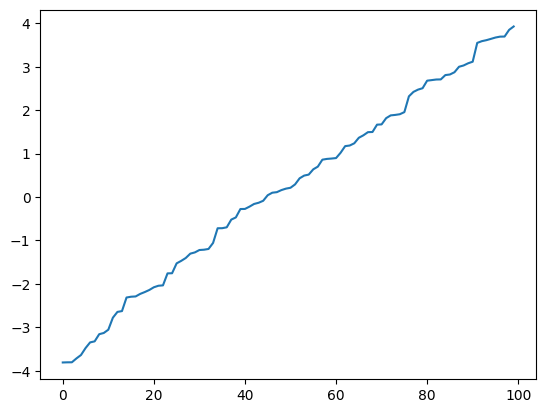

In [155]:
plt.plot(jnp.arange(0,100), jnp.sort(sample.uniform(-4,4, sample_shape=(100,))))


In [174]:
cdf_value

Array([[6.95772032e-05, 7.05757775e-05, 7.08340522e-05, 1.01038408e-04,
        1.37485302e-04, 2.52640137e-04, 4.07964544e-04, 4.44900506e-04,
        7.93327461e-04, 8.72423814e-04, 1.12472521e-03, 2.72971159e-03,
        4.08034120e-03, 4.31750994e-03, 1.03412867e-02, 1.08558796e-02,
        1.10393865e-02, 1.28583014e-02, 1.43270334e-02, 1.61640048e-02,
        1.88681241e-02, 2.05343813e-02, 2.09783334e-02, 3.93685363e-02,
        3.96588631e-02, 6.33478463e-02, 7.07632899e-02, 8.01612437e-02,
        9.61879194e-02, 1.01117074e-01, 1.11219764e-01, 1.12579286e-01,
        1.15933150e-01, 1.45289272e-01, 2.36076981e-01, 2.36480564e-01,
        2.42862463e-01, 3.01742733e-01, 3.19371969e-01, 3.91090930e-01,
        3.92093927e-01, 4.12615776e-01, 4.36588585e-01, 4.47528750e-01,
        4.65556026e-01, 5.16811371e-01, 5.39710641e-01, 5.44671655e-01,
        5.63465476e-01, 5.76749384e-01, 5.84535241e-01, 6.14403367e-01,
        6.66804552e-01, 6.89325154e-01, 6.97346747e-01, 7.383222

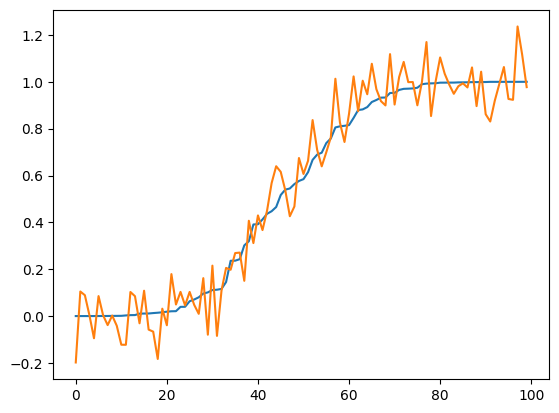

In [187]:
raw = sample.uniform(-4,4, sample_shape=(100,))
raw  = jnp.sort(raw)
sequence = jnp.array([i for i in range(1, 11) for _ in range(10)])
unique = jnp.unique(jnp.array(sequence))
result = []

for i in range(0,len(unique)):  
    result.append(jnp.mean(raw[jnp.where(sequence==(i + 1))], axis = 0))

Dmat = gaus.distance_matrix(jnp.array(result))
cdf_value = norm.cdf(raw , loc=0, scale=1)# to plot for after
plt.plot(jnp.arange(0, 100), cdf_value)
error = sample.normal(0, 0.1, sample_shape=(100,))
y = cdf_value + error
plt.plot(jnp.arange(0, 100), y)

In [188]:
def gaus_model(Dmat, y ,sequence):
    a = dist.normal('a', 0,1)
    sigma = dist.exponential('s', 1)
    etasq = dist.exponential("etasq",2)
    rhosq = dist.exponential("rhosq",0.5)
    sigmaq = dist.exponential("sigmaq",2)

    SIGMA = cov_GPL2(Dmat, etasq, rhosq, sigmaq)
    L_SIGMA = jnp.linalg.cholesky(SIGMA)
    z = dist.normal('z', 0, 1, sample_shape= [10])
    k = numpyro.deterministic("k", (L_SIGMA @ z[..., None])[..., 0])
    
    mu = a + k[sequence]

    lk('Y', Normal(mu, sigma), obs=y)

dat = dict(
    Dmat = Dmat,
    y = y,
    sequence = sequence - 1 
)

m = MCMC(NUTS(gaus_model), num_warmup=500, num_samples=500, num_chains=1)
m.run(random.PRNGKey(0), **dat)
res = az.from_numpyro(m)


sample: 100%|██████████| 1000/1000 [03:53<00:00,  4.29it/s, 191 steps of size 2.40e-02. acc. prob=0.92]


In [116]:
K

Array([-0.27396825,  0.15240066, -0.08370425, -0.5535025 , -0.4566877 ,
       -0.24475469, -0.5314296 , -0.5517882 ,  0.382401  ,  0.52221215],      dtype=float32)

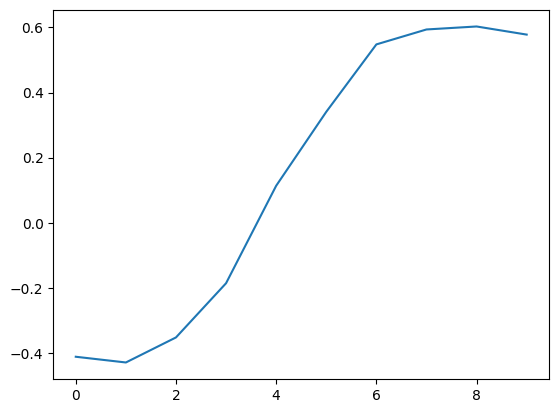

In [190]:
plt.plot(jnp.arange(0,10), jnp.mean(jnp.array(res['posterior']['k'][0,:,:]), axis = 0))

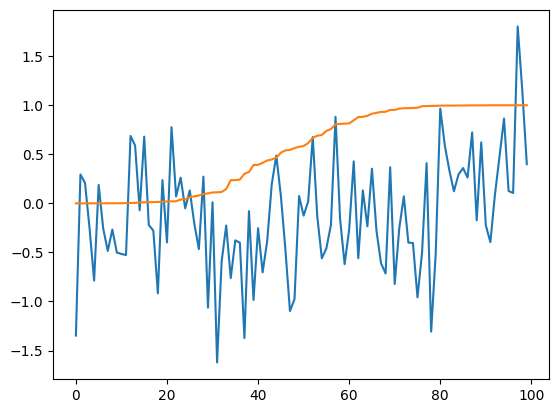

In [143]:
plt.plot(jnp.arange(0,y.shape[0]), y)

plt.plot(jnp.arange(0,cdf_value.shape[1]), cdf_value[1])

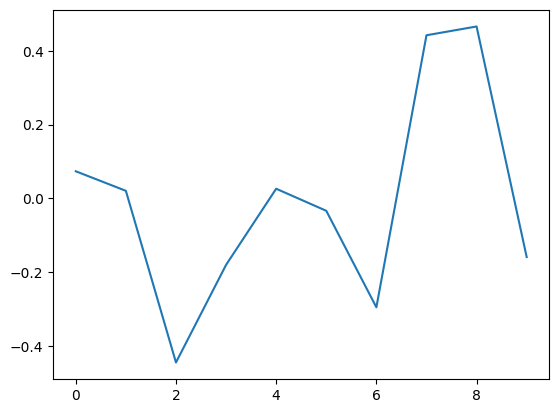

In [120]:
plt.plot(jnp.arange(0,10), jnp.mean(jnp.array(res['posterior']['k'][0,:,:]), axis = 0))

## Combine latent, random and gaussian

In [485]:
# latent + random = random + latent[village[i]] with village being village ID
# gaussian simulation 
# 1. non linear function to generate gaussian proces for each parameters
# model 2 = random + latent[village[i]] + gaussian_process
# model 3  = model 2 + interaction effect
#interaction effect = non linear function where input is hhmembers[i]*offsets[vilage[i]] with new coefficients params
# Within model we need to change offset ouput as an integer so we do bxi*hhmembers[i]*offset[v_ID[i]]+ bxIsq*(hhmembers[i]*offset[v_ID[i]])


# Model on real data

In [486]:
def model(K, ni, y, i_ID):
    #individual 
    Sigma_individual = exponential('Sigma_individual', [ni], 1 )
    L_individual = lkjcholesky('L_individual', [], ni, 50)
    z_individual = normal('z_individual', [ni,K], 0, 1)
    alpha_individual = random_centered2(Sigma_individual, L_individual, z_individual)

    #household 
    Sigma_household = exponential('Sigma_household', [ni], 1 )
    L_household = lkjcholesky('L_household', [], ni, 50)
    z_household = normal('z_household', [ni,K], 0, 1)
    alpha_household = random_centered2(Sigma_household, L_household, z_household)

    #village 
    Sigma_village = exponential('Sigma_village', [ni], 1 )
    L_village = lkjcholesky('L_village', [], ni, 50)
    z_village = normal('z_village', [ni,K], 0, 1)
    alpha_village = random_centered2(Sigma_village, L_village, z_village)

    #LK
    random_factors = alpha_individual[i_ID] + alpha_household[i_ID] + alpha_village[i_ID]
    numpyro.sample("y", dist.DirichletMultinomial(a + random_factors[i_ID], int(12083)), obs=y)

# Test parallelized random centered

In [487]:
init_key, sample_key = random.split(random.PRNGKey(int(r.randint(0, 10000000))))
init_key = jnp.array(init_key)

Sigma_i = Exponential(1).sample(init_key, [ni,])
L_i= LKJCholesky(ni, 1).sample(init_key, [])
z_i= Normal(0, 1).sample([ni,K])
alpha = random_centered(Sigma_i, L_i, z_i)

NameError: name 'ni' is not defined

# Model to latex

In [ ]:
import re
from IPython.display import display, Latex
greek_symbols = {
    'alpha': '\\alpha',
    'beta': '\\beta',
    'gamma': '\\gamma',
    'delta': '\\delta',
    'epsilon': '\\epsilon',
    'zeta': '\\zeta',
    'eta': '\\eta',
    'theta': '\\theta',
    'iota': '\\iota',
    'kappa': '\\kappa',
    'lambda': '\\lambda',
    'mu': '\\mu',
    'nu': '\\nu',
    'xi': '\\xi',
    'omicron': 'o',  # No direct LaTeX symbol for omicron, using "o"
    'pi': '\\pi',
    'rho': '\\rho',
    'sigma': '\\sigma',
    'tau': '\\tau',
    'upsilon': '\\upsilon',
    'phi': '\\phi',
    'chi': '\\chi',
    'psi': '\\psi',
    'omega': '\\omega'
}

def convert_to_greek(var_name):
    # Convert variable name to lowercase for case-insensitive matching
    var_name_lower = var_name.lower()
    # Check if the variable name has a corresponding Greek symbol
    if var_name_lower in greek_symbols:
        return greek_symbols[var_name_lower]
    else:
        return var_name

def extract_latex(command):
    # Define a regular expression pattern to match the desired parts of the command
    pattern = r"(\w+)\s*=\s*(\w+)\([^,]+,\s*[^,]+,\s*(.*)\)"
    match = re.match(pattern, command)
    
    if match:
        var_name = match.group(1)
        func_name = match.group(2)
        params = match.group(3)
        # Convert var_name to Greek symbol if applicable
        var_name_latex = convert_to_greek(var_name)
        # Construct the desired LaTeX text
        latex_text = f"{var_name_latex} = {func_name}({params})"
        return latex_text
    else:
        return None
# Example usage
command = "Sigma_i = exponential('Sigma_individual', [ni], 1)"
latex_text = extract_latex(command)
display(Latex(f'''${latex_text}$'''))

<IPython.core.display.Latex object>

# Proof of concept : function for multiple priors at once:

In [ ]:
import time as tm
from main import*
# setup platform------------------------------------------------
m = bi(platform='cpu')

# import data ------------------------------------------------
m.data('/home/sosa/BI/data/Howell1.csv', sep=';') 
m.data = m.data[m.data .age > 18]
m.data.weight = m.data.weight - m.data.weight.mean()
m.data.age = m.data.age - m.data.age.mean()
weight = jnp.array(m.data.weight.values)
height = jnp.array(m.data.height.values)
# TODO: use jax arrays with hugging face package

m.data = dict(height = height, weight = weight)

def regression_priors():
    s = uniform('s', [1], 0, 50)
    a = normal('a', [1], 178, 20)
    b = normal('b', [1], 0, 1)  
    return s, a, b


 # define model ------------------------------------------------
def model(height, weight):
    s, a, b = regression_priors()
    sample("y", Normal(a + b * weight, s), obs=height)

# Run sampler ------------------------------------------------
m.run(model) 
m.sampler.print_summary(0.89)